In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import random
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
import models
from copy import deepcopy
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
sns.set(style="whitegrid")

# Introduction

The data set used for the following analyses describes Airbnb listings in Seattle, Washington compiled April 15, 2019. It can be downloaded [here](http://insideairbnb.com/get-the-data.html) along with data for various other cities throughout the world. 

Throughout the project, multiple predictive models of `price` will be generated given a size 16 subset of the available features in the dataset. The original dataset contained 106 columns, so the truncated data set has lost significant predictive power. Therefore, the goal is to develop the best model possible given the truncated set and gather an understanding of what might be missing from each model. Suggestions for improvement will be made and summarized at the end.

The project was a partial group project for the graduate Data Science course at Johns Hopkins University.  The EDA was group effort where each member was assigned a subset of the truncated features whereas the modeling was an individual effort.  The EDA in this notebook is only of my assigned features.

# Loading Data

Before EDA, the data will be loaded into a DataFrame and truncated based on the decided features which are:
* host_has_profile_pic
* host_identity_verified
* neighbourhood_cleansed
* neighbourhood_group_cleansed
* zipcode 
* property_type
* room_type
* accommodates
* bathrooms
* bedrooms
* beds
* bed_type
* square_feet
* cleaning_fee

In [4]:
np.random.seed(444398)

In [5]:
listings = pd.read_csv("./listings.csv")

In [6]:
listings_original = listings.copy()
listings = listings[["host_has_profile_pic", "host_identity_verified",
                    "neighbourhood_cleansed", "neighbourhood_group_cleansed",
                    "zipcode", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms",
                    "beds", "bed_type", "square_feet", "cleaning_fee", "number_of_reviews", "price"]]

In [7]:
listings.head()

,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,cleaning_fee,number_of_reviews,price
0,t,t,Madrona,Central Area,98122.0,House,Entire home/apt,8,2.5,4,4.0,Real Bed,NaN,$250.00,21,$296.00
1,t,t,Roosevelt,Other neighborhoods,98115.0,House,Private room,2,1.0,1,1.0,Real Bed,NaN,$30.00,63,$82.00
2,t,t,South Delridge,Delridge,98106.0,Guest suite,Entire home/apt,2,1.0,0,1.0,Real Bed,NaN,$45.00,462,$48.00
3,t,t,Wallingford,Other neighborhoods,98103.0,Apartment,Entire home/apt,2,1.0,1,1.0,Real Bed,NaN,$40.00,134,$90.00
4,t,t,Georgetown,Other neighborhoods,98108.0,Apartment,Private room,2,3.0,1,1.0,Real Bed,200.0,$10.00,131,$65.00


In [8]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8459 entries, 0 to 8458
Data columns (total 16 columns):
host_has_profile_pic            8459 non-null object
host_identity_verified          8459 non-null object
neighbourhood_cleansed          8459 non-null object
neighbourhood_group_cleansed    8459 non-null object
zipcode                         8383 non-null float64
property_type                   8459 non-null object
room_type                       8459 non-null object
accommodates                    8459 non-null int64
bathrooms                       8456 non-null float64
bedrooms                        8459 non-null int64
beds                            8458 non-null float64
bed_type                        8459 non-null object
square_feet                     340 non-null float64
cleaning_fee                    7533 non-null object
number_of_reviews               8459 non-null int64
price                           8459 non-null object
dtypes: float64(4), int64(3), object(9)
memor

# Listings EDA
## Price

First, the target `price` will be explored.  As it is clear from the info output above, `price` is currently an object data type. Price should be a float data type so I'll convert it first.  The prices contain non-numeric characters as well so those will be eliminated before converting.

In [9]:
listings['price'] = (listings['price'].apply(lambda x: x.replace("$", ""))
                                      .apply(lambda x: x.replace(",", ""))
                                      .astype('float32'))

Now I'll take a look at descriptive statistics.

In [10]:
listings['price'].describe()

count    8459.000000
mean      156.241165
std       168.728455
min         0.000000
25%        79.000000
50%       113.000000
75%       179.000000
max      5400.000000
Name: price, dtype: float64

From the descriptive statistics, it's clear that `price` is right-skewed. This isn't too surprising. Price is a non-negative bound value.  Now let's take a look at a histogram.

Text(0.5, 1.0, 'Price Histogram')

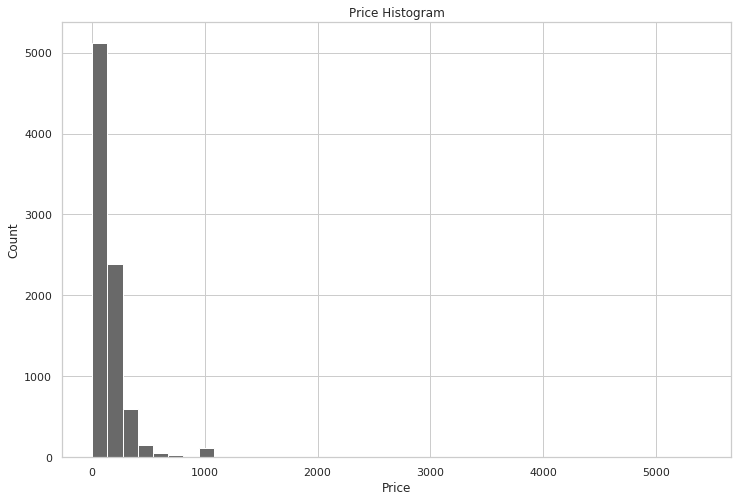

In [11]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.hist(listings.price, bins=40, color='dimgray')
axes.set_xlabel('Price')
axes.set_ylabel('Count')
axes.set_title('Price Histogram')

In [12]:
listings.price.head(25)

0     296.0
1      82.0
2      48.0
3      90.0
4      65.0
5      79.0
6     165.0
7     125.0
8     120.0
9     125.0
10     50.0
11     60.0
12    109.0
13    299.0
14     60.0
15     40.0
16     60.0
17    100.0
18    105.0
19    145.0
20    199.0
21     89.0
22     79.0
23    200.0
24    189.0
Name: price, dtype: float32

Price is certainly skewed right. Notice the spike at \$1000.  People tend to gravitate towards even numbers and will round their listings.  Theoretically, this rounding process limits the predictive accuracy of a typical model.  To explain further, a "perfect" model would be able to predict what the "correct" `price` of a listings should be given its characteristics.  However, since hosts tend to round, the actual price will may be rounded to the nearest 10 or 100 (given the magnitude). Given a significantly accurate model, however, this rounding tendency could be leveraged by rounding the predicted values of the model.


Now let's take a look at `log_price`.  Some listings have a price of 0. To avoid -inf as a `log_price`, if `price`$=0$, then `log_price`$=0$.

In [13]:
def log(x):
    
    result = []
    non_zeros = (x > 0)    
    
    for i, val in enumerate(x):
        if non_zeros[i]:
            result.append(np.log10(val))
        else:
            result.append(np.log10(val+1))
    return np.array(result)

log_price = log(listings['price'])

Text(0.5, 1.0, 'Log Price Histogram')

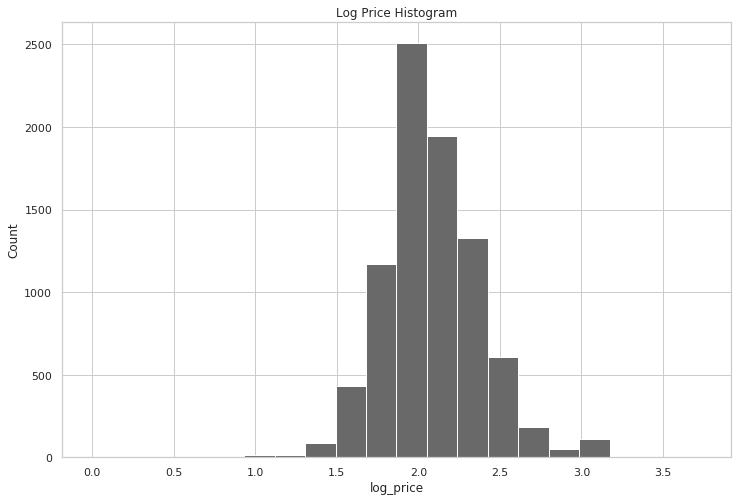

In [14]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.hist(log_price, bins=20, color='dimgray')
axes.set_xlabel('log_price')
axes.set_ylabel('Count')
axes.set_title('Log Price Histogram')

It appears that `log_price` will could be modeled well with a normal distribution. Therefore, a linear regression, which assumes normality, may perform better when targetting `log_price` than `price`.

## Property Type

This field is categorical.  Let's take a look at the counts of each value.

In [15]:
listings.property_type.value_counts()

House                 2839
Apartment             2811
Guest suite            741
Townhouse              724
Condominium            484
Guesthouse             228
Serviced apartment     178
Loft                   108
Bungalow                96
Cottage                 42
Aparthotel              40
Other                   22
Cabin                   22
Boat                    21
Bed and breakfast       20
Tiny house              20
Camper/RV               19
Houseboat               15
Hostel                   7
Tent                     7
Villa                    4
Boutique hotel           3
Yurt                     2
Nature lodge             1
Farm stay                1
Resort                   1
Chalet                   1
In-law                   1
Treehouse                1
Name: property_type, dtype: int64

A majority of the properties are either Houses or Apartments.  Now let's take a look at the mean price values for each property type. 

In [16]:
listings.groupby('property_type').agg(['count', np.mean, np.std])['price'].sort_values('mean')

,count,mean,std
property_type,,,
Treehouse,1,20.000000,NaN
Farm stay,1,35.000000,NaN
Hostel,7,45.285713,15.585402
Aparthotel,40,59.000000,0.000000
In-law,1,75.000000,NaN
Tent,7,77.285713,36.445000
Bed and breakfast,20,89.650002,38.651310
Yurt,2,100.500000,0.707107
Guest suite,741,105.345482,57.501606


From this, we can see that `property_type` has a clear effect on the price of the listing and should be included in the model.  However, many of the labels ave low value counts so it could help to group labels together.

## Bedrooms

Bedrooms is an ordinal categorical variable.  In general, I'd predict more bedrooms to increase the cost of the listing.  Let's look at the same statistics table generated above for `bedrooms`.

In [17]:
listings.groupby('bedrooms').agg(['count', np.mean, np.std])['price'].sort_index()

,count,mean,std
bedrooms,,,
0,989,119.534882,90.320984
1,4789,116.637291,121.559311
2,1617,196.165115,167.499771
3,702,265.864685,259.332611
4,254,325.149597,168.056808
5,76,518.250000,472.623718
6,20,565.549988,209.750854
7,10,542.599976,206.140839
8,2,1150.000000,707.106812


Oddly, the no bedroom listings are about the same average cost as listings with one bedroom.  Let's now take a look at a scatter plot of the price vs. bedrooms.

Text(0.5, 1.0, 'Price vs. Bedrooms Scatter Plot')

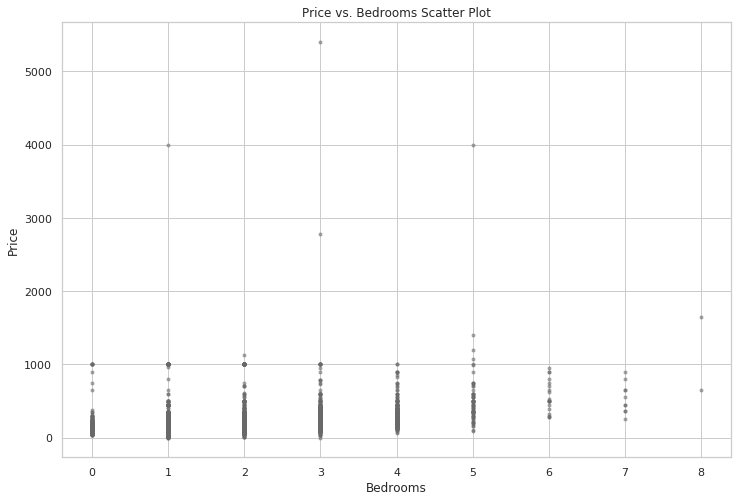

In [18]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(listings.bedrooms, listings.price, '.', color='dimgray', alpha=0.5)
axes.set_xlabel('Bedrooms')
axes.set_ylabel('Price')
axes.set_title('Price vs. Bedrooms Scatter Plot')

The outliers make it somewhat hard to see the general trend.  Let's change the range of the plot.

Text(0.5, 1.0, 'Price vs. Bedrooms Scatter Plot')

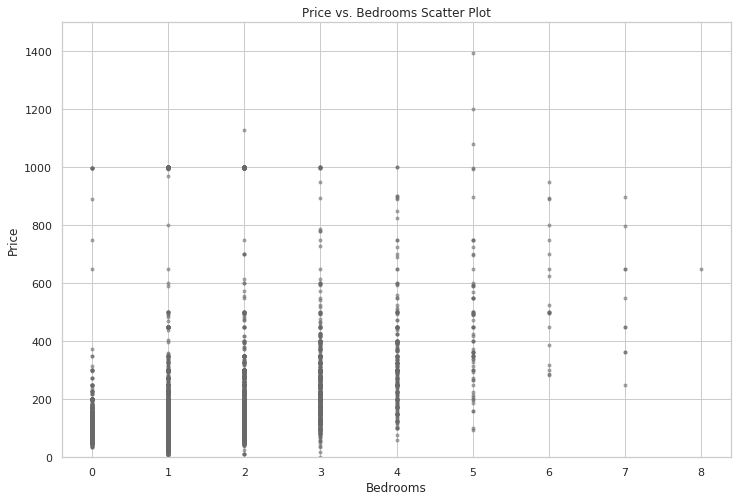

In [19]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(listings.bedrooms, listings.price, '.', color='dimgray', alpha=0.5)
axes.set_xlabel('Bedrooms')
axes.set_ylabel('Price')
axes.set_ylim([0, 1500])
axes.set_title('Price vs. Bedrooms Scatter Plot')

The trend is somewhat more clear now.  There is a slight positive relationship between `bedrooms` and `price`  Let's take a look at `log_price` vs `bedrooms` as `log_price` seems easier to model alone.

Text(0.5, 1.0, 'log_price vs. Bedrooms Scatter Plot')

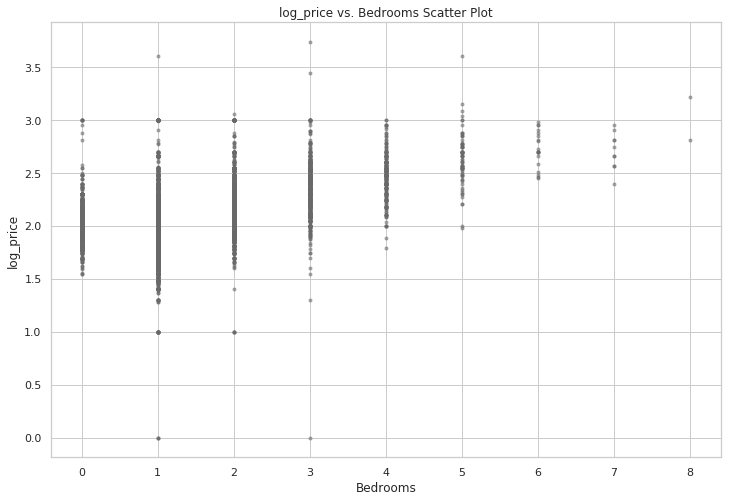

In [20]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(listings.bedrooms, log_price, '.', color='dimgray', alpha=0.5)
axes.set_xlabel('Bedrooms')
axes.set_ylabel('log_price')
#axes.set_ylim([0, 1500])
axes.set_title('log_price vs. Bedrooms Scatter Plot')

The trend is slightly more clear now.  Including `bedrooms` in the models should help.

## Square Feet

`square_feet` is a continuous variable. I predict that `price` increases with `square_feet`.  Let's first take a look at descriptive statistics.

In [21]:
listings.square_feet.describe()

count     340.000000
mean      718.358824
std       343.490388
min         0.000000
25%       600.000000
50%       600.000000
75%      1000.000000
max      2750.000000
Name: square_feet, dtype: float64

From these statistics, it's clear that `square_feet` is a right-skewed.  Considering that the 2nd and 3rd quartile are equal, it's likely that many of the `square_feet` values are estimates.  Let's take a look at the counts.

In [22]:
listings.square_feet.value_counts()

600.0     146
1000.0     62
500.0      22
300.0      17
400.0       9
1200.0      7
1100.0      7
750.0       5
580.0       5
800.0       4
1400.0      4
1500.0      4
900.0       4
1300.0      3
850.0       3
0.0         2
842.0       2
250.0       2
120.0       2
1600.0      2
450.0       2
650.0       2
435.0       1
3.0         1
485.0       1
660.0       1
2.0         1
1800.0      1
1250.0      1
550.0       1
730.0       1
710.0       1
140.0       1
340.0       1
2750.0      1
205.0       1
685.0       1
350.0       1
183.0       1
2000.0      1
2600.0      1
950.0       1
2100.0      1
170.0       1
220.0       1
200.0       1
Name: square_feet, dtype: int64

A significant portion of the listings have the same square feet as expected.  This suggests that many of the values are rough estimates.  Let's take a look at a histogram of the distribution.

Text(0.5, 1.0, 'square_feet Histogram')

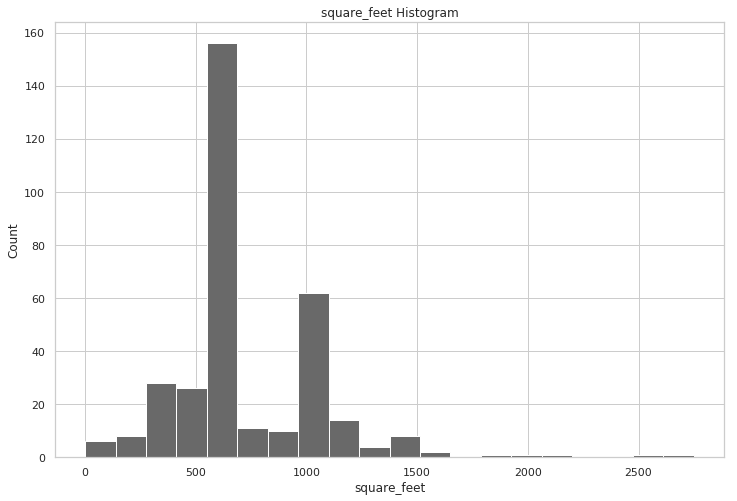

In [23]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.hist(listings.square_feet, bins=20, color='dimgray')
axes.set_xlabel('square_feet')
axes.set_ylabel('Count')
axes.set_title('square_feet Histogram')

There are clear peaks at 1000 and 600 as expected.  Now let's take a look at a scatter plot of `price` vs `square_feet`.

Text(0.5, 1.0, 'price vs. square_feet Scatter Plot')

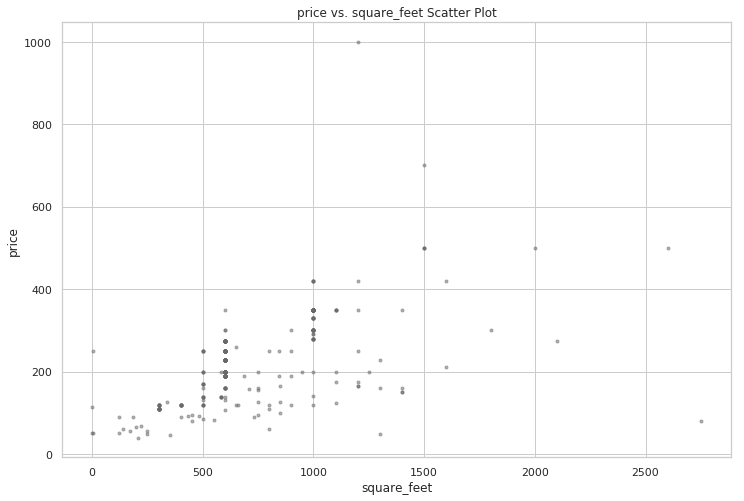

In [24]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(listings.square_feet, listings.price, '.', color='dimgray', alpha=0.5)
axes.set_xlabel('square_feet')
axes.set_ylabel('price')
axes.set_title('price vs. square_feet Scatter Plot')

There's definitely some positive relationship between the two based on this scatter plot.  Let's now take a look at `log_price` vs `square_feet`.

Text(0.5, 1.0, 'log_price vs. square_feet Scatter Plot')

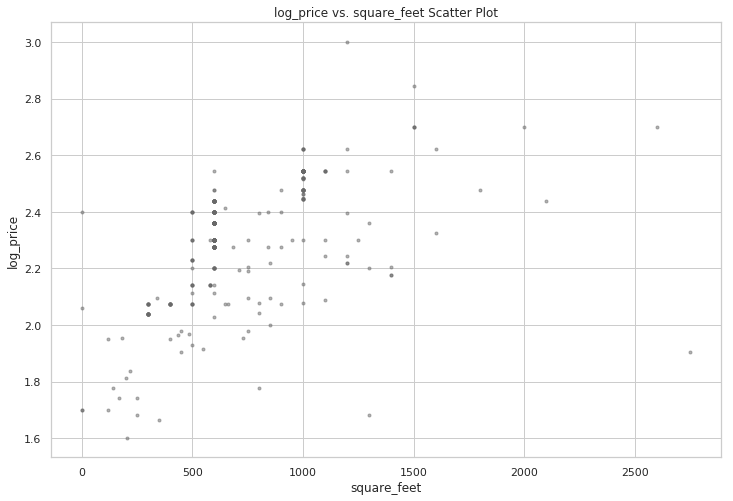

In [25]:
figure = plt.figure(figsize=(12, 8))

axes = figure.add_subplot(1, 1, 1)
axes.plot(listings.square_feet, log_price, '.', color='dimgray', alpha=0.5)
axes.set_xlabel('square_feet')
axes.set_ylabel('log_price')
axes.set_title('log_price vs. square_feet Scatter Plot')

Again, the trend becomes more clear when using `log_price`.  However, there is a high percentage of missing values for `square_feet` so the feature may not be of use.

## Feature Engineering



### Removal of Insignificant Features

Based on the group EDA, several variables will be removed from the feature set which were determined not to have an effect on price or were highly correlated with other variables.

In [26]:
features = list(listings.columns)
pd.Series(features)

0             host_has_profile_pic
1           host_identity_verified
2           neighbourhood_cleansed
3     neighbourhood_group_cleansed
4                          zipcode
5                    property_type
6                        room_type
7                     accommodates
8                        bathrooms
9                         bedrooms
10                            beds
11                        bed_type
12                     square_feet
13                    cleaning_fee
14               number_of_reviews
15                           price
dtype: object

In [27]:
for x in ['bathrooms', 'zipcode', 'neighbourhood_cleansed']:
    features.remove(x)

### Missing Value Handling

Some of the features to be included have missing values, so we have to handle those.

In [28]:
listings[features].isna().sum()

host_has_profile_pic               0
host_identity_verified             0
neighbourhood_group_cleansed       0
property_type                      0
room_type                          0
accommodates                       0
bedrooms                           0
beds                               1
bed_type                           0
square_feet                     8119
cleaning_fee                     926
number_of_reviews                  0
price                              0
dtype: int64

The missing values for `cleaning_fee` will be replaced with 0.  If a host doesn't list a `cleaning_fee`, it's probably because there isn't one.  The column will also be converted into a float datatype.  

`square_feet` is missing for most of listings. It may be best to drop `square_feet` due to the high percentage of missing values.  However, because of the positive correlation between it and `price` that was discovered during EDA and the fact that the features have already been truncated, it will not be removed. The missing values will be replaced with the imputed mean and the missing values will be marked in an attempt to generate some predictive value from the feature.  In a more complex model, k Nearest Neighbors could be used to impute `square_feet` more accurately.

In [29]:
listings['cleaning_fee'].fillna(0, inplace=True)

def make_float(x):
    if isinstance(x, str):
        x = x.replace("$", "")
        x = x.replace(",", "")
        x = float(x)
        
    return x

listings['cleaning_fee'] = listings['cleaning_fee'].apply(make_float)

In [30]:
listings["beds"].fillna(np.mean(listings.beds), inplace=True)

In [31]:
listings["square_feet_na"] = listings['square_feet'].isna().astype('int64')
listings["square_feet"].fillna(np.mean(listings.square_feet), inplace=True)




### One Hot Encoding

Now one hot encoding will be used for all the categorical features.

In [32]:
listings = listings[features]
listings = pd.get_dummies(listings, drop_first=False)

All white spaces in columns will now be removed so that they can be used with patsy. '-' and '/' will be removed as well.

In [33]:
listings.columns = listings.columns.str.replace(" ", "")
listings.columns = listings.columns.str.replace("-", "")
listings.columns = listings.columns.str.replace("/", "")

### Adjusted Price

Many hosts opt to encompass their cleaning fee into the overall price of the rental.  In order to adjust for this, we can model the sum of `price` and `cleaning_fee` as well as the log of the sum.  These can then be reverse engineered to model `price`.

In [34]:
adj_price = listings['price']+listings['cleaning_fee']
log_adj_price = np.log(adj_price)

## Mean Model
Before any linear regression, the mean will be calculated as a baseline for each of the proposed initial target before inversion to `price` (if necessary).

In [35]:
print("Mean Price: {0:.3f}".format( np.mean(listings.price)))
print("Std Price: {0:.3f}".format( np.std(listings.price)))

Mean Price: 156.241
Std Price: 168.718


Now the same will be done with `log_price`.

In [36]:
print("Mean log_price: {0:.3f}".format( np.mean(log_price)))
print("Std log_price: {0:.3f}".format( np.std(log_price)))

Mean log_price: 2.079
Std log_price: 0.295


Now the same will be done with `adj_price` and `log_adj_price`

In [37]:
print("Mean adj_price: {0:.3f}".format( np.mean(adj_price)))
print("Std adj_price: {0:.3f}".format( np.std(adj_price)))

Mean adj_price: 220.315
Std adj_price: 201.284


In [38]:
print("Mean log_adj_price: {0:.3f}".format( np.mean(log_adj_price)))
print("Std log_adj_price: {0:.3f}".format( np.std(log_adj_price)))

Mean log_adj_price: 5.147
Std log_adj_price: 0.682


## Linear Regression

The following functions will assist with creating formulas that can be used with patsy.

In [39]:
def make_formula(target, predictors):
    
    formula = target + " ~ "
    for index, p in enumerate(predictors, 1):
        if index==len(predictors):
            formula = formula + p
        else:
            formula = formula + p + " + "
    
    return formula
                

In [40]:
def add_interaction(formula, feature_1, feature_2):
    return formula + " + " + feature_1 + ":" + feature_2

def add_predictor(formula, predictor):
    return formula + " + " + predictor

In [41]:
features = list(listings.columns)
features.remove("price")
formula = make_formula("price", features)

### Price as Target - All Features
The model will use `price` as the target and include all the predictors available.  The `model.py` file included allows for bootstrap regression which will provide credible intervals for coefficients and evaluation statistics.

In [42]:
results = models.bootstrap_linear_regression(formula, data=listings)
display(models.describe_bootstrap_lr(results))
print("Adjusted R2: {0:.3f}".format(models.adjusted_r_squared(results)))

Adjusted R2: 0.307


### log_price as Target - All Features

From EDA, it was clearly that taking the log of price produced a normal distribution, which hypothetical should perform better linear regression.  However, the goal it to predict `price` not `log_price`, therefore if `log_price` is used as a target, it needs to be inverted back to `price`. `TransformedTargetRegressor` will help with this process.  The `models` module does not include a function that perform this currently so unfortunately coefficients will not be shown here.  However, a bootstrap can still be performed and the evaluation statistics can be observed.  The `bootstrap_transformed` function borrows some of the code in models to do this.  

Interaction features were not used in the linear model so patsy is longer required.

The inverse function below will allow `price` to be returned from estimates of `log_price`.

In [43]:
np.random.seed(5329182)

In [44]:
def inverse_log(x):
    return 10**x

In [45]:
def bootstrap_transformed(X, y, estimator, func, inverse_func, samples=100):
    
    if (X is None) or (y is None):
        raise ValueError( "The parameters 'X' and 'y' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "predictors"] = list(X.columns)
    
    sigmas = []
    r2s = []
    maes = []

    n = X.shape[ 0]
    bootstrap_results[ "n"] = n
    
    tt = TransformedTargetRegressor(estimator,
                                    func=func,
                                    inverse_func=inverse_func,
                                    check_inverse=False)
    
    for i in range( samples):
        
        sampling_indices = pd.Index([ i for i in [np.random.randint(0, n - 1) for _ in range( 0, n)]])
        X_sample = X.loc[sampling_indices]
        y_sample = y.loc[sampling_indices]
        
        
        tt.fit(X_sample, y_sample)
        y_predict = tt.predict(X_sample)
        
        sigma = np.sqrt(mean_squared_error(y_sample, y_predict))
        r2 = r2_score(y_sample, y_predict)
        mae = mean_absolute_error(y_sample, y_predict)
        
        sigmas.append(sigma)
        r2s.append(r2)
        maes.append(mae)
        
    # Get a set of residuals
    tt.fit(X, y)
    y_predict = tt.predict(X)
    bootstrap_results["residuals"] = y-y_predict
        
    bootstrap_results[ "resampled_mae"] = maes
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = r2s
    

    # Find credible intervals
    mae_cred = np.array2string(stats.mstats.mquantiles(maes, [0.25, .975]), precision=3, separator=',')
    sigma_cred = np.array2string(stats.mstats.mquantiles(sigmas, [0.25, .975]), precision=3, separator=',')
    r2_cred = np.array2string(stats.mstats.mquantiles(r2s, [0.25, .975]), precision=3, separator=',')

    
    # Print results
    print("MAE Resample Mean: {0:.3f}".format(np.mean(maes)))
    print("95% Credible Interval for MAE: ", mae_cred)
    print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigmas)))
    print("95% Credible Interval for sigma: ", sigma_cred)
    print("R2 Resample Mean: {0:.3f}".format(np.mean(r2s)))
    print("95% Credible Interval for R2: ", r2_cred)
    
    
    return bootstrap_results

In [46]:
X = listings.drop(columns=['price'])
y = listings['price']
estimator = LinearRegression()
results = bootstrap_transformed(X, y, estimator, log, inverse_log)

MAE Resample Mean: 54.765
95% Credible Interval for MAE:  [53.758,57.426]
Sigma Resample Mean: 143.348
95% Credible Interval for sigma:  [134.872,170.754]
R2 Resample Mean: 0.277
95% Credible Interval for R2:  [0.256,0.342]


Surprisingly, this did not help, it may be because the inverse function and the transformation function are not true inverses (as a consequence of having some listings with 0 price).  This could result in worse evaluation statistics.  In addition, the inverse function produces an exponential growth with predictions. 

### adj_price - All Features

Now, the same will be done with  to see if the feature engineering improved the model. This time we're looking at whether or not `adj_price` = `price` + `cleaning_fee` is easier to model.  We can go back to using the bootstrap regression from models this time.  Now that `cleaning_fee`, however, is included in part of the target, it can no longer be used as a predictor.

In [47]:
np.random.seed(902893)

In [48]:
listings['adj_price'] = listings['price'] + listings['cleaning_fee']
features = list(listings.columns)
features.remove("price")
features.remove("adj_price")
features.remove('cleaning_fee')
formula = make_formula("adj_price", features)

In [49]:
results = models.bootstrap_linear_regression(formula, data=listings)
display(models.describe_bootstrap_lr(results))
print("Adjusted R2: {0:.3f}".format(models.adjusted_r_squared(results)))

Adjusted R2: 0.416


This is a significant improvement over the previous models in terms of $R^{2}$ which supports the assumption that true price is the sum  of `price` and `cleaning_fee`, assuming that true price would be easier to model.

### log_adj_price as Target - All Features

Now we'll see if taking the log of adjusted price helps the model.

In [50]:
np.random.seed(423)

In [51]:
X = listings.drop(columns=['price', 'adj_price', 'cleaning_fee'])
y = listings['adj_price']
estimator = LinearRegression()
results = bootstrap_transformed(X, y, estimator, log, inverse_log)

MAE Resample Mean: 70.236
95% Credible Interval for MAE:  [69.03 ,73.335]
Sigma Resample Mean: 159.484
95% Credible Interval for sigma:  [151.524,182.359]
R2 Resample Mean: 0.376
95% Credible Interval for R2:  [0.354,0.441]


This is certainly an improvement over using `log_price` as the target but `adj_price` still results in the best evaluation statistics.   However, since the difference between the results of targetting `adj_price` and `price` aren't particularly large, we'll stick with targetting `price`, since that's the overall goal. Using `adj_price` as an initial target and subtracting `cleaning_fee` from predictions to convert back to `price` is still certainly a possible improvement for future models.

In [52]:
listings = listings.drop(columns=['adj_price'])

### Numeric Features only  
Let's look at a model with just the numeric features.  The binary features will be added in progressively. 

In [53]:
np.random.seed(52209)

In [54]:
features = ['accommodates', 'bedrooms', 'beds', 'square_feet', "number_of_reviews", "cleaning_fee"]
formula = make_formula("price", features)
results = models.bootstrap_linear_regression(formula, data=listings)
display(models.describe_bootstrap_lr(results))
print("Adjusted R2: {0:.3f}".format(models.adjusted_r_squared(results)))

Adjusted R2: 0.246


The evaluation statistics have worsened significantly.  Let's see if we can increase it by manipulating just these numeric variables.  The encoded categorical variables will be added later as mentioned before.  Based on EDA, taking the log of number of reviews may help.  Let's try that.

In [55]:
listings["log_reviews"] = log(listings["number_of_reviews"])

In [56]:
features = ['accommodates', 'bedrooms', 'beds', 'square_feet', "log_reviews", "cleaning_fee"]
formula = make_formula("price", features)
results = models.bootstrap_linear_regression(formula, data=listings)
print(models.describe_bootstrap_lr(results))
print("Adjusted R2: {0:.3f}".format(models.adjusted_r_squared(results)))

Adjusted R2: 0.254


This seems to have helped a little bit.  Let's try the same with `square_feet`.

In [57]:
listings["log_square_feet"] = log(listings["square_feet"])

In [58]:
features = ['accommodates', 'bedrooms', 'beds', 'log_square_feet', "log_reviews", "cleaning_fee"]
formula = make_formula("price", features)
results = models.bootstrap_linear_regression(formula, data=listings)
display(models.describe_bootstrap_lr(results))
print("Adjusted R2: {0:.3f}".format(models.adjusted_r_squared(results)))

Adjusted R2: 0.254


This didn't seem to help so we'll stick with `square_feet`

In [59]:
listings = listings.drop(columns=["log_square_feet"])

### Adding in Binary Features

Now, we'll add in the other features in iteratively if adding the feature increasing the $R^{2}$ score by a value greater than delta.

In [60]:
np.random.seed(253029)

In [61]:
def add_features(data, target, current_features, additional_features, delta=0.01):
    
    # Set baseline with current features
    current_formula = make_formula(target=target, predictors=current_features)
    baseline_results = models.bootstrap_linear_regression(current_formula, data=data)
    baseline_r2 = models.adjusted_r_squared(baseline_results)
    current_r2 = baseline_r2
    
    for new_feature in additional_features:
        
        candidate_formula = add_predictor(current_formula, new_feature)
        candidate_results = models.bootstrap_linear_regression(candidate_formula, data=data)
        candidate_r2 = models.adjusted_r_squared(candidate_results)
        difference = candidate_r2-current_r2
        
        print("Tested Formula: ", candidate_formula)
        print("Added Feature: ", new_feature)
        print("Adjusted R2: {0:.3f}".format(candidate_r2))
        print("Increase in Adjusted R2: {0:.3f}".format(difference))
        print() #newline
        
        if difference > delta:
            current_formula = candidate_formula
            current_results = candidate_results
            current_r2 = candidate_r2
    
    total_increase = current_r2 - baseline_r2
    print("Final Formula: ", current_formula)
    print("Final Adjusted R2: {0:.3f}".format(current_r2))
    print("Total increase in Adjusted R2 {0:.3f}".format(total_increase))
    display(models.describe_bootstrap_lr(current_results))
    
    return current_formula, current_results
    
    
    

In [62]:
current_features = ['accommodates', 'bedrooms', 'beds', 'square_feet', "log_reviews", "cleaning_fee"]
additional_features = list(listings.columns)

for x in current_features:
    additional_features.remove(x)
    
for x in ['price', 'number_of_reviews']:
    additional_features.remove(x)

In [63]:
formula, results = add_features(listings, 
                                "price", 
                                current_features=current_features,
                                additional_features=additional_features,
                                delta=0.003)

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + host_has_profile_pic_f
Added Feature:  host_has_profile_pic_f
Adjusted R2: 0.254
Increase in Adjusted R2: -0.000

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + host_has_profile_pic_t
Added Feature:  host_has_profile_pic_t
Adjusted R2: 0.254
Increase in Adjusted R2: -0.000

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + host_identity_verified_f
Added Feature:  host_identity_verified_f
Adjusted R2: 0.257
Increase in Adjusted R2: 0.003

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + host_identity_verified_t
Added Feature:  host_identity_verified_t
Adjusted R2: 0.257
Increase in Adjusted R2: 0.003

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + neighbourhood_group_cleansed_Ball

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + neighbourhood_group_cleansed_Downtown + property_type_Apartment + property_type_Cottage
Added Feature:  property_type_Cottage
Adjusted R2: 0.295
Increase in Adjusted R2: -0.000

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + neighbourhood_group_cleansed_Downtown + property_type_Apartment + property_type_Farmstay
Added Feature:  property_type_Farmstay
Adjusted R2: 0.295
Increase in Adjusted R2: -0.000

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + neighbourhood_group_cleansed_Downtown + property_type_Apartment + property_type_Guestsuite
Added Feature:  property_type_Guestsuite
Adjusted R2: 0.295
Increase in Adjusted R2: -0.000

Tested Formula:  price ~ accommodates + bedrooms + beds + square_feet + log_reviews + cleaning_fee + neighbourhood_group_cleansed_Downtown + property_type_


While this model doesn't reach the mean $R^{2}$ that the model with all potential predictors did, it is just short and the credible intervals overlap significantly.  The new model also uses significantly fewer features.

### Residuals
Now that a suitable formula has been found, residuals will be plotted against the numerical features.

Text(0, 0.5, 'residuals')

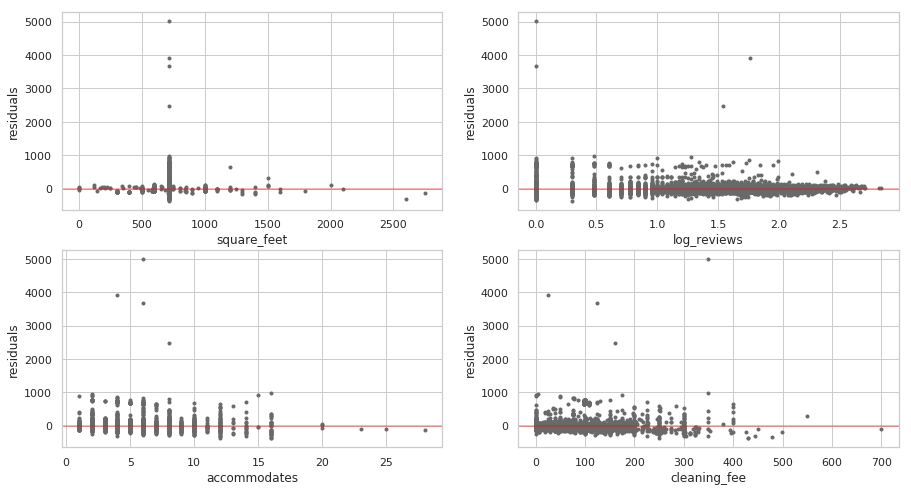

In [64]:
residuals = results["residuals"]

figure = plt.figure(figsize=(15, 8))

axes = figure.add_subplot(2, 2, 1)
axes.plot(listings.square_feet, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('square_feet')
axes.set_ylabel('residuals')


axes = figure.add_subplot(2, 2, 2)
axes.plot(listings.log_reviews, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('log_reviews')
axes.set_ylabel('residuals')

axes = figure.add_subplot(2, 2, 3)
axes.plot(listings.accommodates, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('accommodates')
axes.set_ylabel('residuals')

axes = figure.add_subplot(2, 2, 4)
axes.plot(listings.cleaning_fee, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('cleaning_fee')
axes.set_ylabel('residuals')


While there are patterns here, there aren't any clear non-normal distribution residual patterns that can be handled easily. In general, it appears as the there are distinct outliers which are difficult to model.  

In the `square_feet` plot, the high number of listings that were estimated to be 600 square feet is evident.  Engineering a new binary featuring representing this may help improve the accuracy of the model.


### Learning Curve

Now Learning Curves will be plotted to determine if gathering more data will help and determine the bias/variance tradeoff.

In [65]:
np.random.seed(5329139)

In [66]:
def learning_curve(data, formula, estimator, chunks=50, test_size=0.2, iterations=50):
    
    n = data.shape[0]
    test_n = int(np.round(n*test_size,0))
    train_n = n-test_n
    
    indices = deepcopy(data.index).values
    random.shuffle(indices)
    
    test_indices = indices[0:test_n]
    train_indices = indices[test_n:]
    
    train_set = data.iloc[train_indices]
    test_set = data.iloc[test_indices]
    
    test_y, test_X = dmatrices(formula, test_set)
    
    size_interval = train_n/chunks
    sizes = [int(size_interval*i) for i in range(1, chunks+1)]
    
    train = []
    test = []
    train_std = []
    test_std = []
    
    for s in sizes:
        
        train_chunk = []
        test_chunk = []
        
        
        for _ in range(iterations):
            
            train_sample = train_set.sample(n=s)
            train_y, train_X = dmatrices(formula, train_sample)

            estimator.fit(train_X, train_y)
            test_score = estimator.score(test_X, test_y)
            train_score = estimator.score(train_X, train_y)
            
            train_chunk.append(train_score)
            test_chunk.append(test_score)
            
        train.append(np.mean(train_chunk))
        test.append(np.mean(test_chunk))
        train_std.append(np.std(train_chunk))
        test_std.append(np.std(test_chunk))
        
    learning = pd.DataFrame({'size':sizes,
                  'train':train,
                  'train_std': train_std,
                  'test':test,
                  'test_std': test_std})
    
    
    # Getting bounds of confidence interval
    estimator_name = str(estimator).split('(')[0]
    train_upper = learning['train'] + learning['train_std']
    train_lower = learning['train'] - learning['train_std']
    test_upper = learning['test'] + learning['test_std']
    test_lower = learning['test'] - learning['test_std']
    
    # Plotting the curve
    figure = plt.figure(figsize=(12, 8))

    axes = figure.add_subplot(1, 1, 1)
    axes.plot(learning["size"], learning["train"], '-', label='train', color ='firebrick')
    axes.plot(learning["size"], learning["test"], '-', label='test', color = 'steelblue')
    axes.fill_between(learning["size"], train_upper, train_lower, color='firebrick', alpha=0.25)
    axes.fill_between(learning["size"], test_upper, test_lower, color='steelblue', alpha=0.25)
    axes.legend()
    axes.set_xlabel("size")
    axes.set_ylabel(r"$R^{2}$")
    axes.set_title("Learning Curve for " + estimator_name)
    
    plt.show()
    plt.close()
    
    return learning

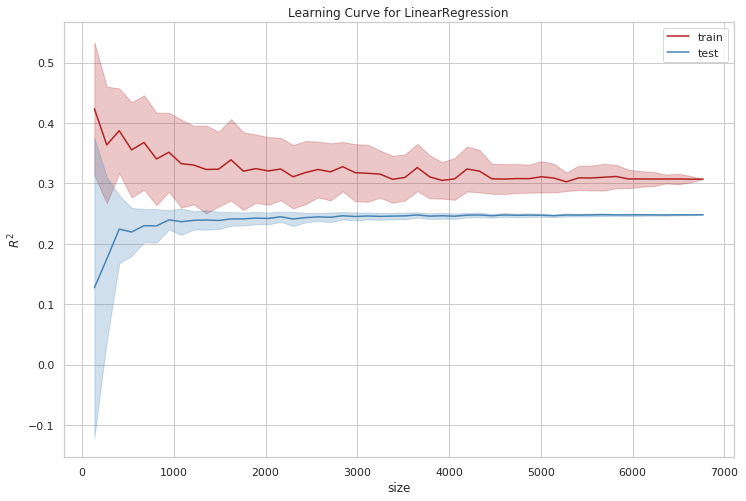

In [67]:
learning = learning_curve(listings, formula, LinearRegression())

Both curves have leveled which suggests more data would would not improve the model. There is still a gap between the test and train curve so there is some variance.  The $R^{2}$ is low at 0.30 for both curves around which suggests a high level of bias.  Let's see if a Decision Tree Regressor performs better.

## Decision Tree Regression

Linear Regression didn't produce as high of an $R^{2}$ as desired.  Decision Tree regression will be used next which hopefully should make better use of the categorical variables.

### Validation Curves

Validation Curves will be produced to determine the optimal tree depth.  Other parameters will be left as default.  The scoring for splits will be means squared error.

In [68]:
np.random.seed(5443275)

In [69]:
def validation_curve(data, target, estimator, parameter, param_range, scoring='r2', cv=10, iterations=20):
    
    train = []
    test = []
    train_std = []
    test_std = []
    data_copy = data.copy()
    
    for value in param_range:
        
        train_param = []
        test_param = []
        
        x = {parameter: value}
        estimator = estimator.set_params(**x)
        
        for _ in range(iterations):
            
            # Shuffle data set
            indices = deepcopy(data_copy.index).values
            random.shuffle(indices)
            data_copy = data_copy.iloc[indices].reset_index(drop=True)
            
            # Get iteration score and append to parameter value score list
            score = cross_validate(estimator, data_copy.drop(columns=[target]), data_copy[target],
                                   scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)            
            train_param.append(score['train_score'])
            test_param.append(score['test_score'])
        
        # Append mean/std score with param val to validation score list                          
        train.append(np.mean(train_param))
        test.append(np.mean(test_param))
        train_std.append(np.std(train_param))
        test_std.append(np.std(test_param))
        
    validation = pd.DataFrame({'param_vals':param_range,
                               'train':train,
                               'train_std':train_std,
                               'test':test,
                               'test_std': test_std})
    
    # Getting bounds of confidence interval
    estimator_name = str(estimator).split('(')[0]
    train_upper = validation['train'] + validation['train_std']
    train_lower = validation['train'] - validation['train_std']
    test_upper = validation['test'] + validation['test_std']
    test_lower = validation['test'] - validation['test_std']
    
    # Plotting the curve
    figure = plt.figure(figsize=(12, 8))

    axes = figure.add_subplot(1, 1, 1)
    axes.plot(validation["param_vals"], validation["train"], '-', label='train', color ='firebrick')
    axes.plot(validation["param_vals"], validation["test"], '-', label='test', color = 'steelblue')
    axes.fill_between(validation["param_vals"], train_upper, train_lower, color='firebrick', alpha=0.25)
    axes.fill_between(validation["param_vals"], test_upper, test_lower, color='steelblue', alpha=0.25)
    axes.legend()
    axes.set_xlabel(parameter)
    axes.set_ylabel(scoring)
    axes.set_title("Validation Curve of " + parameter + " for " + estimator_name)
    axes.set_xticks(param_range)
    
    plt.show()
    plt.close()
    
        
    return validation

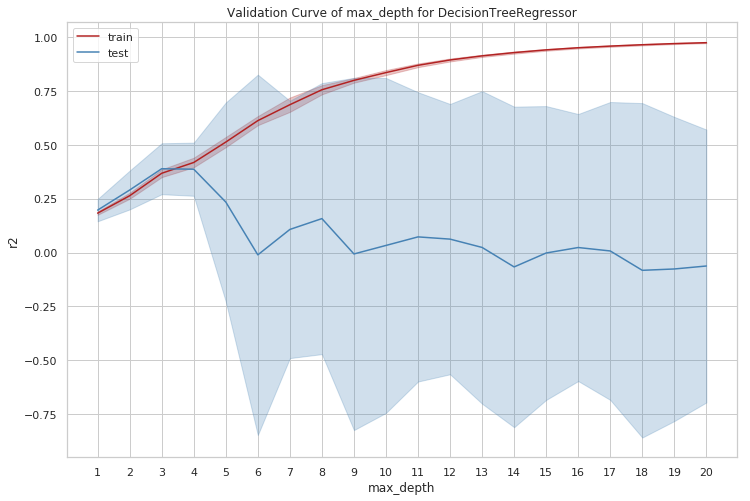

In [70]:
estimator = DecisionTreeRegressor()
param_range = range(1, 21)

validation = validation_curve(listings, "price", estimator, "max_depth", param_range)

From the validation curve, it can be concluded that 3 is the optimal `max_depth`.  Also note that the width of the confidence interval is very large.  This indicates that some test sets were much more difficult to model than others.

### Learning Curve

Now the learning curve will be plotted to determine whether or not more data would help.

In [71]:
np.random.seed(52109)

In [72]:
def learning_curve_2(data, target, estimator, chunks=50, test_size=0.2, iterations=50):
    
    n = data.shape[0]
    test_n = int(np.round(n*test_size,0))
    train_n = n-test_n
    
    indices = deepcopy(data.index).values
    random.shuffle(indices)
    
    test_indices = indices[0:test_n]
    train_indices = indices[test_n:]
    
    train_set = data.iloc[train_indices]
    test_set = data.iloc[test_indices]
    
#     test_y, test_X = dmatrices(formula, test_set)
    
    size_interval = train_n/chunks
    sizes = [int(size_interval*i) for i in range(1, chunks+1)]
    
    train = []
    test = []
    train_std = []
    test_std = []
    
    for s in sizes:
        
        train_chunk = []
        test_chunk = []
        
        
        for _ in range(iterations):
            
            train_sample = train_set.sample(n=s)
#             train_y, train_X = dmatrices(formula, train_sample)

            estimator.fit(train_sample.drop(columns=[target]), train_sample[target])
            test_score = estimator.score(test_set.drop(columns=[target]), test_set[target])
            train_score = estimator.score(train_sample.drop(columns=[target]), train_sample[target])
            
            train_chunk.append(train_score)
            test_chunk.append(test_score)
            
        train.append(np.mean(train_chunk))
        test.append(np.mean(test_chunk))
        train_std.append(np.std(train_chunk))
        test_std.append(np.std(test_chunk))
        
    learning = pd.DataFrame({'size':sizes,
                  'train':train,
                  'train_std': train_std,
                  'test':test,
                  'test_std': test_std})
    
    
    # Getting bounds of confidence interval
    estimator_name = str(estimator).split('(')[0]
    train_upper = learning['train'] + learning['train_std']
    train_lower = learning['train'] - learning['train_std']
    test_upper = learning['test'] + learning['test_std']
    test_lower = learning['test'] - learning['test_std']
    
    # Plotting the curve
    figure = plt.figure(figsize=(12, 8))

    axes = figure.add_subplot(1, 1, 1)
    axes.plot(learning["size"], learning["train"], '-', label='train', color ='firebrick')
    axes.plot(learning["size"], learning["test"], '-', label='test', color = 'steelblue')
    axes.fill_between(learning["size"], train_upper, train_lower, color='firebrick', alpha=0.25)
    axes.fill_between(learning["size"], test_upper, test_lower, color='steelblue', alpha=0.25)
    axes.legend()
    axes.set_xlabel("size")
    axes.set_ylabel(r"$R^{2}$")
    axes.set_title("Learning Curve for " + estimator_name)
    
    plt.show()
    plt.close()
    
    return learning

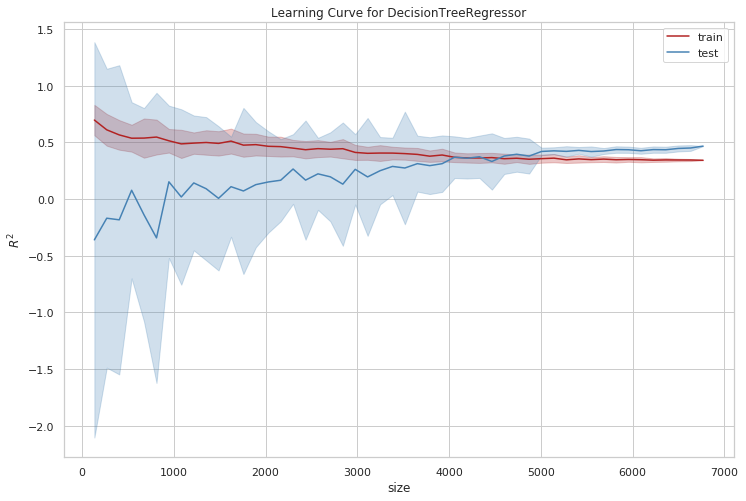

In [73]:
estimator = DecisionTreeRegressor(max_depth=3)
learning = learning_curve_2(listings, "price", estimator)


The training curve and test curve leveled out so more data would not improve the model. Notice that the test curve actually score higher towards the size limit than the training curve.   This will be discussed more later.

### Cross Validation Bootstrap

Now that the optimal value for `max_depth` has been found, a credible interval for both sigma and $R^{2}$ can be developed.  This credible interval can then be compared to one gathered from the linear regression model. A few functions will be developed below to assist with this.  Mean Absolute Error will also be measured after this point as another means for comparison.  It's possible that large errors from outliers have spiked sigma and these errors will not affect MAE as drastically. 

In [74]:
np.random.seed(53132)

In [75]:
def multi_cross_val(data, target, estimator, cv=10, n=3):
    
    scores = {'sigma': np.array([]), 
              'r2': np.array([]),
              'mae': np.array([])}
    
    data_copy = data.copy()
    
    for _ in range(n):
        
        indices = deepcopy(data_copy.index).values
        random.shuffle(indices)
        data_copy = data_copy.iloc[indices]
        
        score = cross_validate(estimator, data_copy.drop(columns=[target]), data_copy[target],
                               scoring=['r2', 
                                        'neg_mean_squared_error',
                                        'neg_mean_absolute_error'],
                               return_train_score=False, cv=cv, n_jobs=-1)
        
        scores['sigma'] = np.append(scores['sigma'], np.sqrt(-score['test_neg_mean_squared_error']))
        scores['r2'] = np.append(scores['r2'], score['test_r2'])
        scores['mae'] = np.append(scores['mae'], -score['test_neg_mean_absolute_error'])
        
    return scores

In [76]:
def multi_cross_val_formula(data, formula, estimator, cv=10, n=3):
    
    scores = {'sigma': np.array([]), 
              'r2': np.array([]),
              'mae': np.array([])}
    
    data_copy = data.copy()
    
    for _ in range(n):
        
        indices = deepcopy(data_copy.index).values
        random.shuffle(indices)
        data_copy = data_copy.iloc[indices]
        
        y, X = dmatrices(formula, data_copy, return_type="matrix")
        score = cross_validate(estimator, X, y, scoring=['r2', 
                                                         'neg_mean_squared_error',
                                                         'neg_mean_absolute_error'], 
                               return_train_score=False, cv=cv)
        
        scores['sigma'] = np.append(scores['sigma'], np.sqrt(-score['test_neg_mean_squared_error']))
        scores['r2'] = np.append(scores['r2'], score['test_r2'])
        scores['mae'] = np.append(scores['mae'], -score['test_neg_mean_absolute_error'])
        
    return scores

In [77]:
def bootstrap_sample(data, f, n=100):
    
    results = []
    for _ in range(n):
        sample = np.random.choice(data, len(data), replace=True)
        r = f(sample)
        results.append(r)
    
    return np.array(results)
    

The linear regression bootstrap cross validation will be processed first.

In [78]:
linear_cv = multi_cross_val_formula(listings, formula, LinearRegression())

# Resample scores_linear
sigma_linear_resample = bootstrap_sample(linear_cv["sigma"], np.mean)
r2_linear_resample = bootstrap_sample(linear_cv["r2"], np.mean)
mae_linear_resample = bootstrap_sample(linear_cv["mae"], np.mean)

# Find credible intervals
sigma_linear_cred = np.array2string(stats.mstats.mquantiles(sigma_linear_resample, [0.25, .975]), precision=3, separator=',')
r2_linear_cred = np.array2string(stats.mstats.mquantiles(r2_linear_resample, [0.25, .975]), precision=3, separator=',')
mae_linear_cred = np.array2string(stats.mstats.mquantiles(mae_linear_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigma_linear_resample)))
print("95% Credible Interval for sigma: ", sigma_linear_cred)
print("R2 Resample Mean: {0:.3f}".format(np.mean(r2_linear_resample)))
print("95% Credible Interval for R2: ", r2_linear_cred)
print("mae Resample Mean: {0:.3f}".format(np.mean(mae_linear_resample)))
print("95% Credible Interval for mae: ", mae_linear_cred)

Sigma Resample Mean: 136.243
95% Credible Interval for sigma:  [131.955,148.678]
R2 Resample Mean: 0.326
95% Credible Interval for R2:  [0.319,0.359]
mae Resample Mean: 63.848
95% Credible Interval for mae:  [63.161,65.837]


In [79]:
# Get scores
estimator = DecisionTreeRegressor(max_depth=4)
scores = multi_cross_val(listings, 'price', estimator)

# Resample Scores
sigma_resample = bootstrap_sample(scores["sigma"], np.mean)
r2_resample = bootstrap_sample(scores["r2"], np.mean)
mae_resample = bootstrap_sample(scores["mae"], np.mean)

# Find credible intervals
sigma_cred = np.array2string(stats.mstats.mquantiles(sigma_resample, [0.25, .975]), precision=3, separator=',')
r2_cred = np.array2string(stats.mstats.mquantiles(r2_resample, [0.25, .975]), precision=3, separator=',')
mae_cred = np.array2string(stats.mstats.mquantiles(mae_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigma_resample)))
print("95% Credible Interval for sigma: ", sigma_cred)
print("R2 Resample Mean: {0:.3f}".format(np.mean(r2_resample)))
print("95% Credible Interval for R2: ", r2_cred)
print("mae Resample Mean: {0:.3f}".format(np.mean(mae_resample)))
print("95% Credible Interval for mae: ", mae_cred)

Sigma Resample Mean: 128.935
95% Credible Interval for sigma:  [122.886,146.726]
R2 Resample Mean: 0.390
95% Credible Interval for R2:  [0.38 ,0.439]
mae Resample Mean: 59.364
95% Credible Interval for mae:  [58.909,60.62 ]


Now the difference between the bootstraps can be calculated for $R^{2}$ and sigma.

In [80]:
difference = {}
difference["sigma"] = sigma_resample - sigma_linear_resample
difference["r2"] = r2_resample - r2_linear_resample

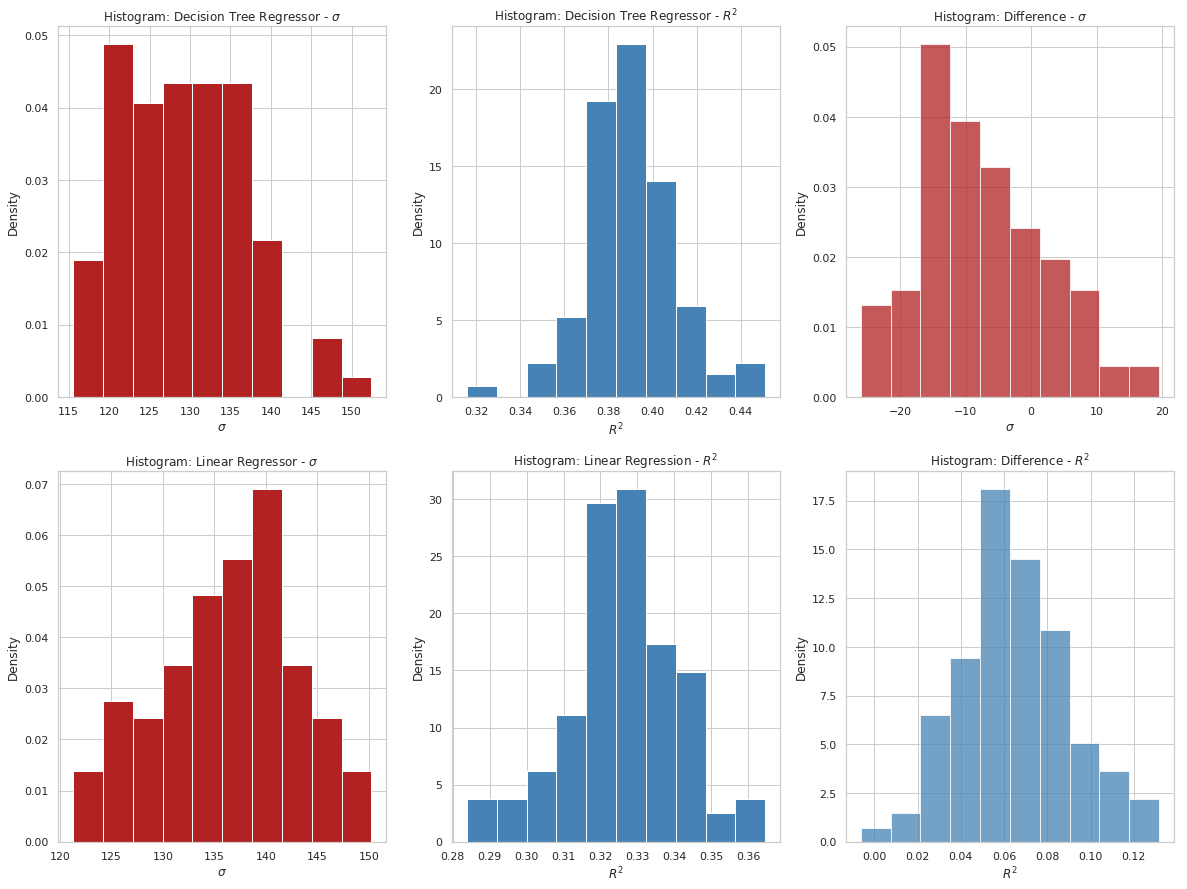

In [81]:
figure = plt.figure(figsize=(20, 15))

axes = figure.add_subplot(2, 3, 1)
axes.hist(sigma_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Decision Tree Regressor - $\sigma$")
# axes.set_xlim([4100, 5000])

axes = figure.add_subplot(2, 3, 4)
axes.hist(sigma_linear_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Linear Regressor - $\sigma$")
# axes.set_xlim([4100, 5000])

axes = figure.add_subplot(2, 3, 3)
axes.hist(difference["sigma"], color='firebrick', density=True, alpha=0.75)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Difference - $\sigma$")

axes = figure.add_subplot(2, 3, 2)
axes.hist(r2_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Decision Tree Regressor - $R^{2}$")
# axes.set_xlim([.82, .88])

axes = figure.add_subplot(2, 3, 5)
axes.hist(r2_linear_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Linear Regression - $R^{2}$")
# axes.set_xlim([.82, .88])

axes = figure.add_subplot(2, 3, 6)
axes.hist(difference["r2"], color='steelblue', density=True, alpha=0.75)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Difference - $R^{2}$")

plt.show()
plt.close()

We can also measure the probability that the Decision Tree Regressor produces an $R^{2}$ greater than the linear regression.

In [82]:
print("P(R^2 Decision Tree > R^2 Linear) = ", np.mean(difference["r2"]>0))

P(R^2 Decision Tree > R^2 Linear) =  0.99


In terms of $R^{2}$, it's almost certain that the Decision Tree Regressor performed better than the Linear Regression.

### Visualizing the Tree

In [83]:
np.random.seed(5214512)

In [84]:
features = list(listings.columns)
features.remove("price")

In [85]:
model = DecisionTreeRegressor(max_depth=4)
model.fit(listings[features], listings["price"])

export_graphviz(model, 
                out_file='tree.dot', 
                feature_names= features,
                rotate=True)

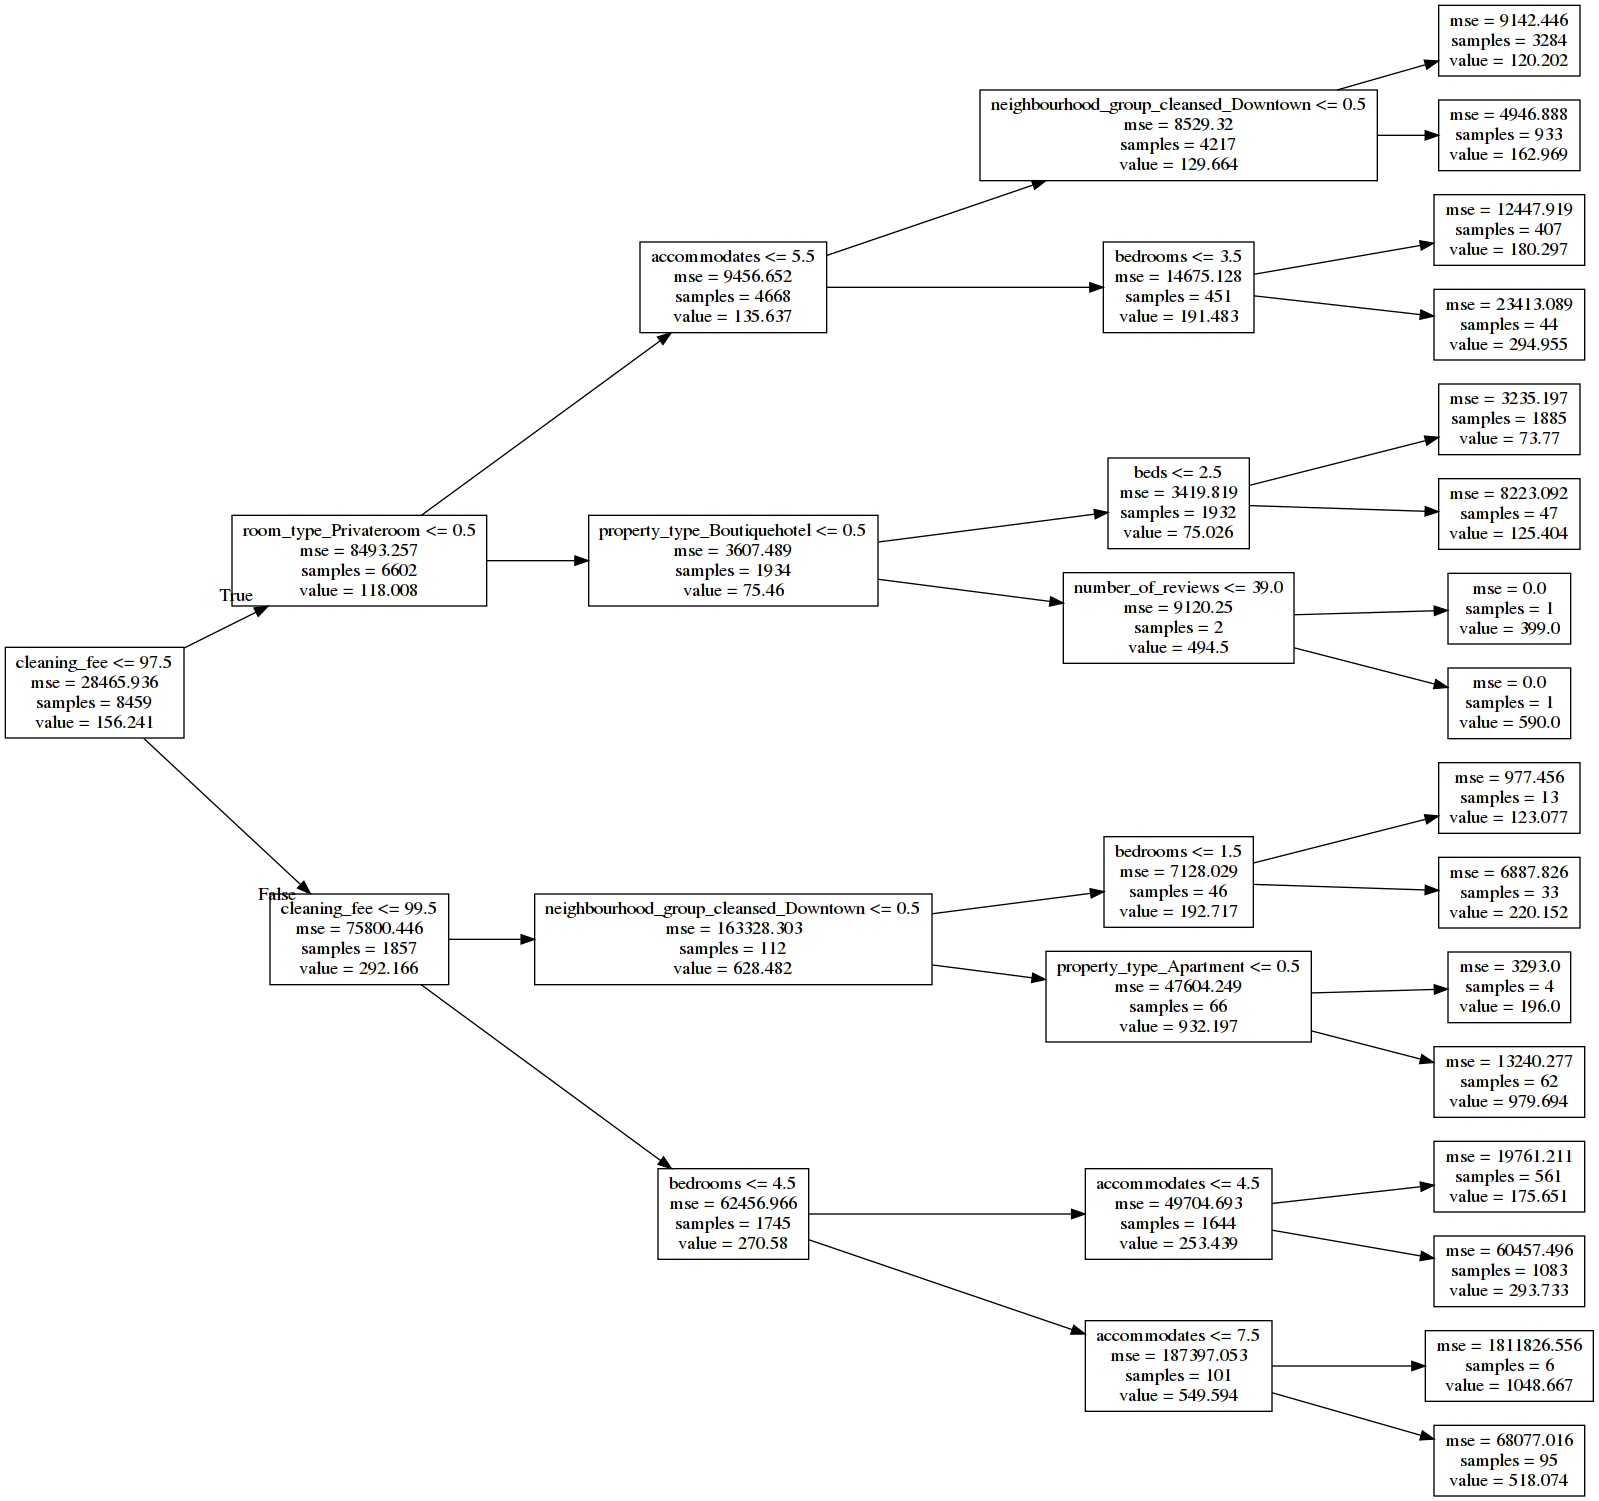

In [86]:
from IPython.display import Image
Image(filename='tree.png')

## Random Forest

A Random Forest model will now be used to see if any further improvements can be made.  

### Grid Search
Validation Curves will be used to optimize the parameters.  A grid search will be used to find a starting point for hyperparameters to use for the validation curves.

In [87]:
np.random.seed(520912)

In [88]:
features = list(listings.columns)

In [89]:
# Defining param grid to search
n_estimators = [int(x) for x in np.linspace(start=1, stop=50, num=5)]
max_depth = [2, 4, 6, 8, 10, 12, 14, 16]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 4, 6, 8, 10, 12]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

estimator = RandomForestRegressor()

grid_search = GridSearchCV(estimator,
                           param_grid = param_grid,
                           n_jobs=-1,
                           scoring='r2',
                           verbose=1
                           )

grid_search.fit(listings.drop(columns=["price"]), listings["price"])

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 766 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 1966 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  2.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 13, 25, 37, 50], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=1)

In [90]:
best_params = grid_search.best_params_
best_params

{'max_depth': 14,
 'min_samples_leaf': 6,
 'min_samples_split': 2,
 'n_estimators': 25}

### Validation Curves
#### n_estimators

The first validation curve will be generated to optimize the `n_estimators` parameter.

In [91]:
np.random.seed(5420891)

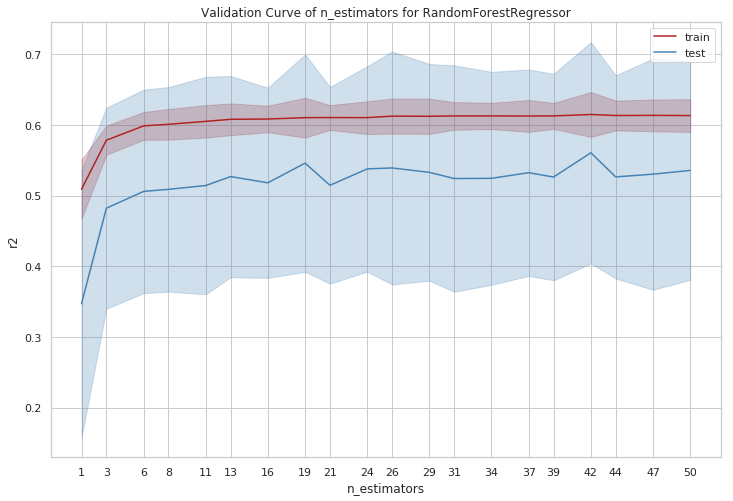

In [92]:
estimator = RandomForestRegressor().set_params(**best_params)
param_range = [int(x) for x in np.linspace(start=1, stop=50, num=20)]
validation = validation_curve(listings[features], "price", estimator, 
                              'n_estimators', param_range, iterations=3)

After 10, any increases in $R^{2}$ are marginal.  The validation curve will now be repeated with a more dense parameter range.

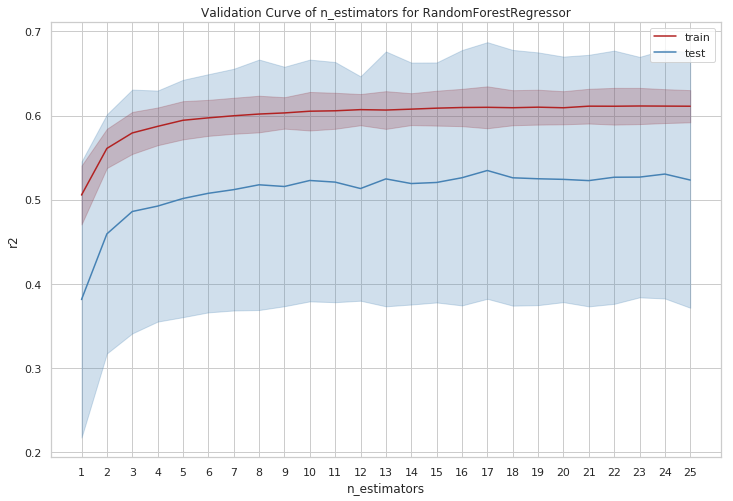

In [93]:
estimator = RandomForestRegressor().set_params(**best_params)
param_range = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
validation = validation_curve(listings[features], "price", estimator, 
                              'n_estimators', param_range, iterations=10)

It appears that `n_estimators`=9 is optimal based on this validation curve.  There is still a significant difference between the the train and test curve, however, which suggests high variance.

In [94]:
best_params['n_estimators'] = 9
estimator = RandomForestRegressor().set_params(**best_params)

#### max_depth
Validation Curves will now be produced for `max_depth`.

In [95]:
np.random.seed(125123)

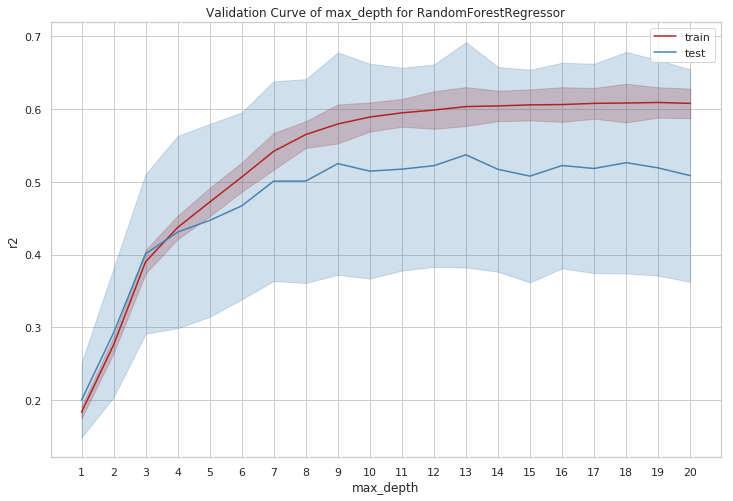

In [96]:
param_range = list(range(1, 21))
validation = validation_curve(listings[features], "price", estimator, 
                              'max_depth', param_range, iterations=5)

The test curve stops increasing steadily after a `max_depth` of 9 so that will be the value used moving forward.  However, there are arguments to be made for values less than 9 where there is less variance.

In [97]:
best_params['max_depth'] = 9
estimator = RandomForestRegressor().set_params(**best_params)

#### min_samples_leaf
Validation Curves will now be produced for `min_samples_leaf`.

In [98]:
np.random.seed(451209)

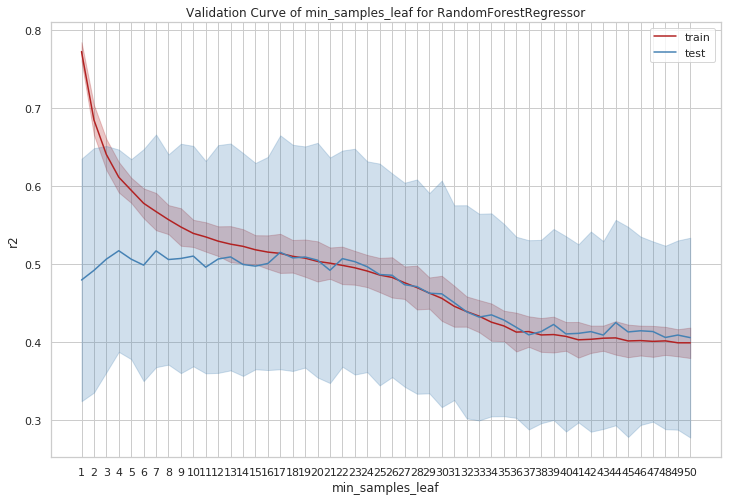

In [99]:
param_range = list(range(1, 51))
validation = validation_curve(listings[features], "price", estimator, 
                              'min_samples_leaf', param_range, iterations=3)

The optimal choice appears to be around 15 here with low variance and bias.

In [100]:
best_params['min_samples_leaf'] = 15
estimator = RandomForestRegressor().set_params(**best_params)

#### min_samples_split
Validation Curves will now be produced for `min_samples_split`.

In [101]:
np.random.seed(523287)

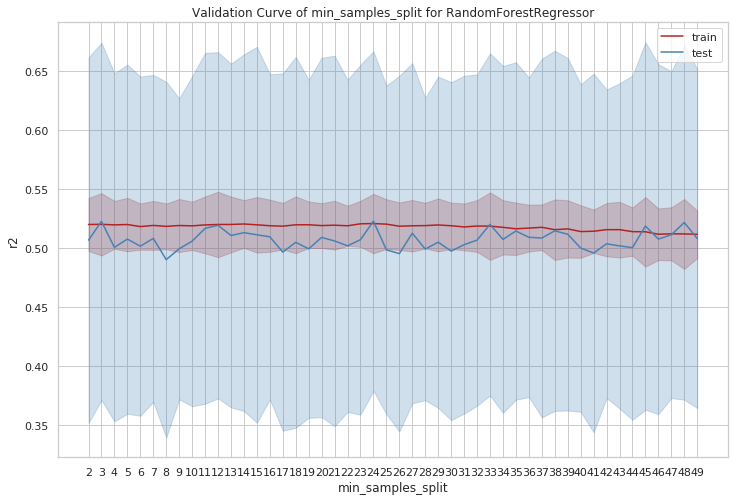

In [102]:
param_range = list(range(2, 50))
validation = validation_curve(listings[features], "price", estimator, 
                              'min_samples_split', param_range, iterations=3)

Tuning `min_samples` split doesn't appear to provide much benefit. We'll set it to 16 but many of these value would work.

In [103]:
best_params['min_samples_split'] = 16
estimator = RandomForestRegressor().set_params(**best_params)

### Learning Curve

Now Learning Curves will be plotted to determine if more data would improve the performance of the model.

In [104]:
np.random.seed(806583)

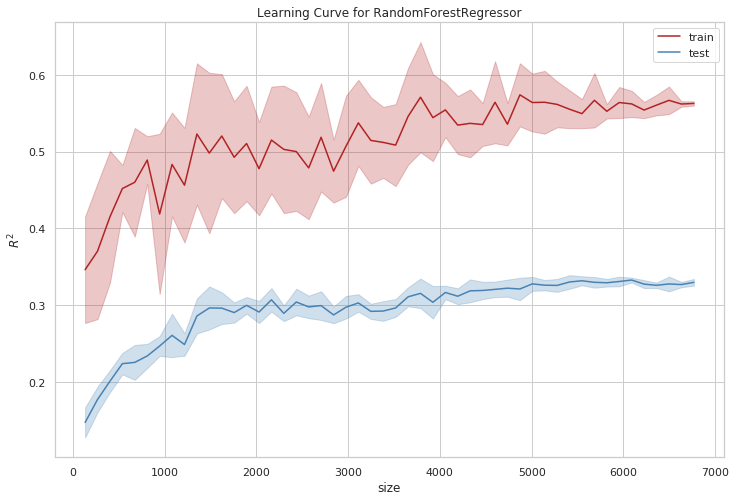

In [105]:
learning = learning_curve_2(listings, "price", estimator, iterations=10, chunks=50)

The $R^{2}$ for test set is higher than the training set when using the validation curves.  If we look back at our validation curves, however, it's not surprising; the upper and lower bound range generally spanned $0.30 R^{2}$ The validation curves select a new test for each iteration whereas the learning curve maintains the same test set. This implies that for the above learning curve, the test set chosen was one of the easier-to-model sets that could have been chosen.

Let's pick a different seed and see if the results differ.

In [106]:
np.random.seed(31421409)

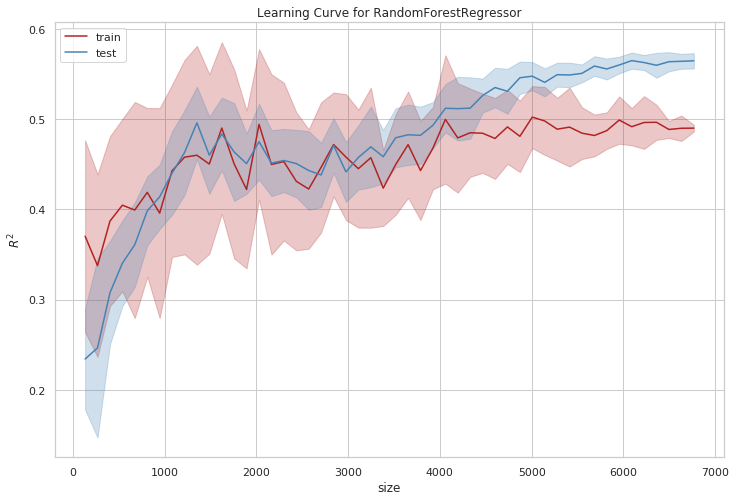

In [107]:
learning = learning_curve_2(listings[features], "price", estimator, iterations=20, chunks=50)

With this run, the $R^{2}$ is significantly lower for the test set. This confirms the belief that there are some selections for the test set that are difficult to model which implies that there are some listings that are hard to model.  These are most likely outliers.  There are several possible solutions to this: oversampling low likelihood price bins, using more features, or applying a different algorithm.

On another note, for both plots and both curves, the slope is still positive with all the data available.  This suggest that more data would improve the model.  For now, we'll do a cross-validation bootstrap on the model as it is. 

### Cross Validation Bootstrap

Now that the hyperparamters have been tuned, a 10-fold cross-evaluation will be performed 3 times.  Resampling on the distribution will then be performed so that a credible interval for both $\sigma$ and $R^{2}$ can be found.

In [108]:
np.random.seed(93024)

In [109]:
# Get scores
estimator = RandomForestRegressor().set_params(**best_params)
scores_rf = multi_cross_val(listings[features], 'price', estimator)

# Resample Scores
sigma_rf_resample = bootstrap_sample(scores_rf["sigma"], np.mean)
r2_rf_resample = bootstrap_sample(scores_rf["r2"], np.mean)
mae_rf_resample = bootstrap_sample(scores_rf["mae"], np.mean)

# Find credible intervals
sigma_rf_cred = np.array2string(stats.mstats.mquantiles(sigma_rf_resample, [0.25, .975]), precision=3, separator=',')
r2_rf_cred = np.array2string(stats.mstats.mquantiles(r2_rf_resample, [0.25, .975]), precision=3, separator=',')
mae_rf_cred = np.array2string(stats.mstats.mquantiles(mae_rf_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigma_rf_resample)))
print("95% Credible Interval for sigma: ", sigma_rf_cred)
print("R2 Resample Mean: {0:.3f}".format(np.mean(r2_rf_resample)))
print("95% Credible Interval for R2: ", r2_rf_cred)
print("mae Resample Mean: {0:.3f}".format(np.mean(mae_rf_resample)))
print("95% Credible Interval for mae: ", mae_rf_cred)

Sigma Resample Mean: 116.751
95% Credible Interval for sigma:  [111.196,133.013]
R2 Resample Mean: 0.510
95% Credible Interval for R2:  [0.49 ,0.555]
mae Resample Mean: 51.658
95% Credible Interval for mae:  [51.242,53.155]


At first glance, this appears to be a signficant improvement over the Decision Tree Regressor.  Let's plot the difference between the bootstraps for each and take a look at the probability that the Random Forest Regressor performs better than the Decision Tree Regressor.

In [110]:
difference = {}
difference["sigma"] = sigma_rf_resample - sigma_resample
difference["r2"] = r2_rf_resample - r2_resample
difference["mae"] = mae_rf_resample - mae_resample

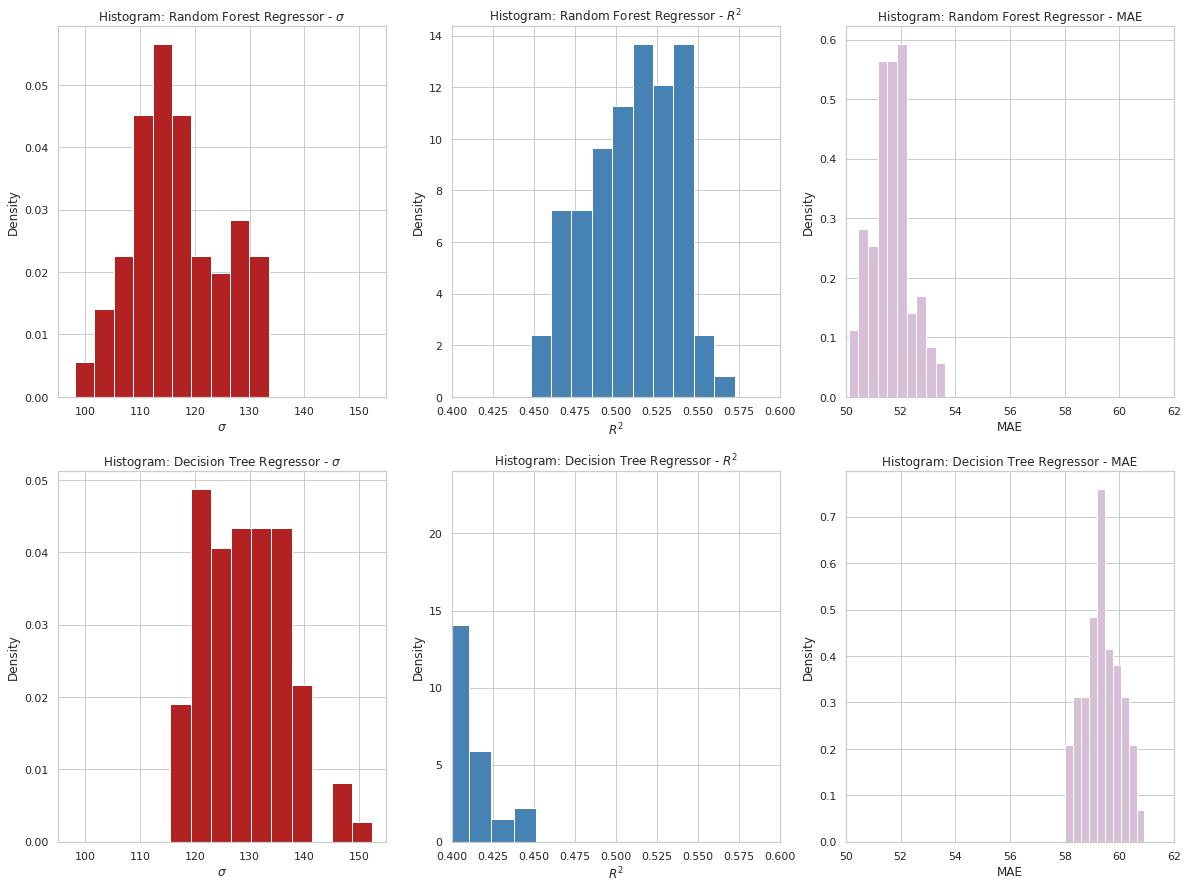

In [111]:
figure = plt.figure(figsize=(20, 15))

axes = figure.add_subplot(2, 3, 1)
axes.hist(sigma_rf_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Random Forest Regressor - $\sigma$")
axes.set_xlim([95, 155])

axes = figure.add_subplot(2, 3, 4)
axes.hist(sigma_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Decision Tree Regressor - $\sigma$")
axes.set_xlim([95, 155])


axes = figure.add_subplot(2, 3, 2)
axes.hist(r2_rf_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Random Forest Regressor - $R^{2}$")
axes.set_xlim([.40, .60])

axes = figure.add_subplot(2, 3, 5)
axes.hist(r2_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Decision Tree Regressor - $R^{2}$")
axes.set_xlim([.40, .60])

axes = figure.add_subplot(2, 3, 3)
axes.hist(mae_rf_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Random Forest Regressor - MAE")
axes.set_xlim([50, 62])

axes = figure.add_subplot(2, 3, 6)
axes.hist(mae_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Decision Tree Regressor - MAE")
axes.set_xlim([50, 62])

plt.show()
plt.close()

The x-axis for each evaluation statistic are aligned for each model to show how the distributions compare.  It's clear from these that the Random Forest Regressor performs better for each statistic.  

Now the differences will be plotted.

/home/sam/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Histogram: Difference - MAE')

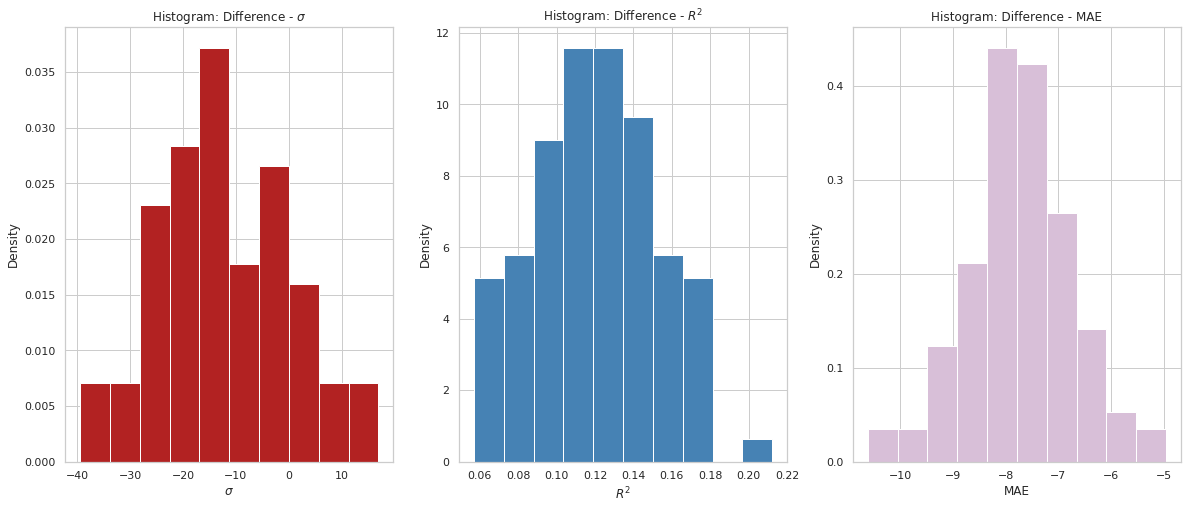

In [112]:
figure = plt.figure(figsize=(20, 8))

axes = figure.add_subplot(1, 3, 1)
axes.hist(difference["sigma"], color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Difference - $\sigma$")


axes = figure.add_subplot(1, 3, 2)
axes.hist(difference["r2"], color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Difference - $R^{2}$")

axes = figure.add_subplot(1, 3, 1)
axes.hist(difference["sigma"], color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Difference - $\sigma$")


axes = figure.add_subplot(1, 3, 3)
axes.hist(difference["mae"], color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Difference - MAE")

In [113]:
print("P(R^2 Random Forest > R^2 Decision Tree) = ", np.mean(difference["r2"]>0))
print("P(sigma Random Forest < sigma Decision Tree) = ", np.mean(difference["sigma"]<0))
print("P(mae Random Forest < sigma Decision Tree) = ", np.mean(difference["mae"]<0))

P(R^2 Random Forest > R^2 Decision Tree) =  1.0
P(sigma Random Forest < sigma Decision Tree) =  0.83
P(mae Random Forest < sigma Decision Tree) =  1.0


This suggests that the Random Forest Regressor almost certainly produces a better $R^{2}$, sigma, and MAE than the Linear Regression on average.

### Feature Importances


In [114]:
np.random.seed(23810931)

In [115]:
estimator = RandomForestRegressor().set_params(**best_params)
X = listings.drop(columns=['price'])
y = listings.price
estimator.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=15, min_samples_split=16,
           min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

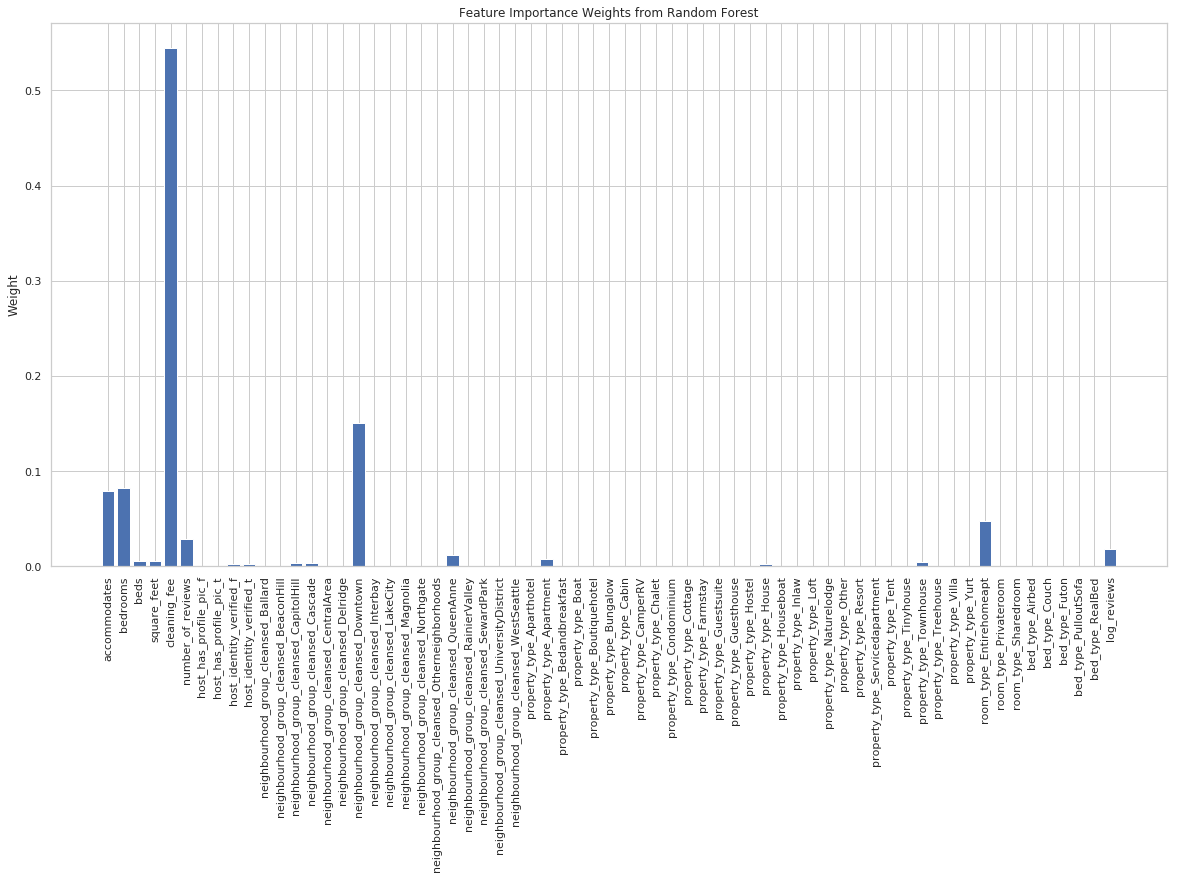

In [116]:
figure = plt.figure(figsize=(20,10))

axes = figure.add_subplot(1, 1, 1)

axes.bar(list(X.columns), estimator.feature_importances_)
axes.set_xticks(np.arange(len(X.columns)))
axes.set_xticklabels(list(X.columns), rotation = 90)

axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Random Forest")

plt.show()
plt.close()

Not surprisingly, `cleaning_fee` is by far the most important feature.  This supports the idea that the true price of a rental is the sum of the `cleaning_fee` and `price`.

### Residuals

As mentioned when discussing the learning curves for the Random Forest model, there are some listings that are more difficult to model.  Let's try to see why the issue arises. 

We'll start by taking a look at the residuals from a single Random Forest model.  The x-axis will be `price`.


In [117]:
np.random.seed(20935)

In [118]:
estimator = RandomForestRegressor().set_params(**best_params)
estimator.fit(listings.drop(columns=['price']), listings['price'])
y_predict = estimator.predict(listings.drop(columns=['price']))
residuals = listings['price'] - y_predict

Text(0, 0.5, 'residuals')

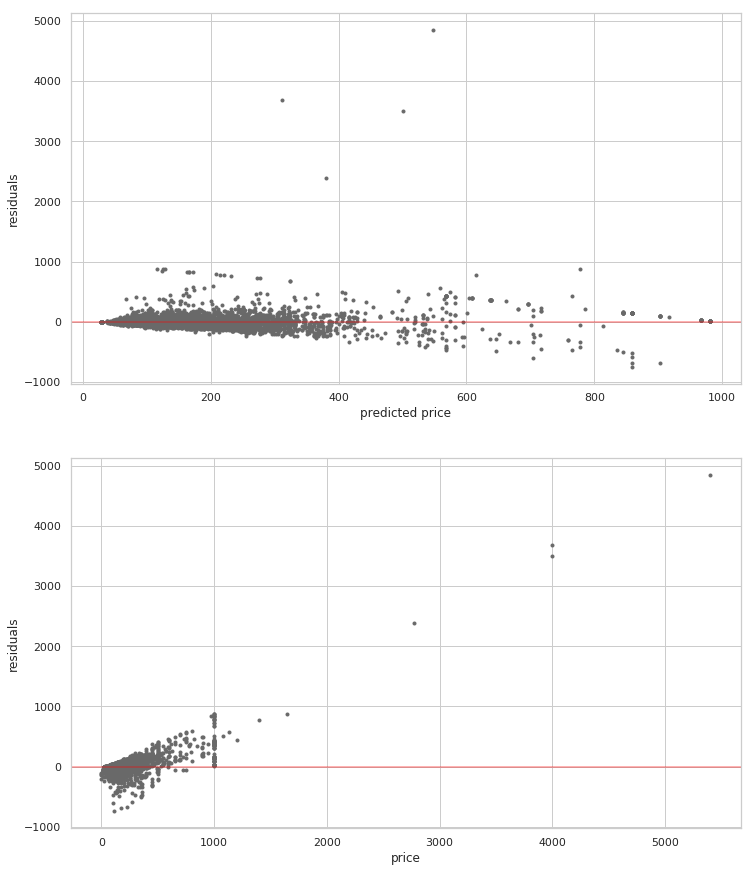

In [119]:
figure = plt.figure(figsize=(12, 15))

axes = figure.add_subplot(2, 1, 1)
axes.plot(y_predict, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('predicted price')
axes.set_ylabel('residuals')

axes = figure.add_subplot(2, 1, 2)
axes.plot(listings.price, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('price')
axes.set_ylabel('residuals')

Notice the clear linear trend.  As price increases, the residuals grow.  One explanation is that a large majority of the listings are at a lower price point, so the tree splits decisions are dominated by those listings.  There may be splits that can help predict those high price point listings, but aren't ever chosen in the model due to scarcity.  It's also likely that the higher price listings are explained by a feature not contained in the truncated feature list. Since there's a clear trend in the residuals, I believe it's most likely something that correlates with price. 

Another option would be oversampling the sparse areas.  However, since the number of features used is low, this could cause issues.

## Gradient Boosting
### Removing Outliers

Before we start, notice notice how sparse the data is past a price of 1000. You can see a linear trend across the length of the residuals which suggest there is a good model possible across all prices ranges.  However, the data is too sparse in that area to help significantly.  Therefore, these points will be removed.

Let's also run a cross validation bootstrap on the truncated data using the same parameters as before to set a baseline for the oversampling.


In [120]:
np.random.seed(2193856)

In [121]:
listings_small = listings.loc[listings.price<1000].reset_index()

In [122]:
# Get scores
estimator = RandomForestRegressor().set_params(n_estimators=9, max_depth=9, min_samples_leaf=15, min_samples_split=16)
scores_rf = multi_cross_val(listings_small, 'price', estimator)

# Resample Scores
sigma_rf_resample = bootstrap_sample(scores_rf["sigma"], np.mean)
r2_rf_resample = bootstrap_sample(scores_rf["r2"], np.mean)
mae_rf_resample = bootstrap_sample(scores_rf["mae"], np.mean)

# Find credible intervals
sigma_rf_cred = np.array2string(stats.mstats.mquantiles(sigma_rf_resample, [0.25, .975]), precision=3, separator=',')
r2_rf_cred = np.array2string(stats.mstats.mquantiles(r2_rf_resample, [0.25, .975]), precision=3, separator=',')
mae_rf_cred = np.array2string(stats.mstats.mquantiles(mae_rf_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigma_rf_resample)))
print("95% Credible Interval for sigma: ", sigma_rf_cred)
print("R2 Resample Mean: {0:.3f}".format(np.mean(r2_rf_resample)))
print("95% Credible Interval for R2: ", r2_rf_cred)
print("mae Resample Mean: {0:.3f}".format(np.mean(mae_rf_resample)))
print("95% Credible Interval for mae: ", mae_rf_cred)

Sigma Resample Mean: 78.728
95% Credible Interval for sigma:  [78.129,80.219]
R2 Resample Mean: 0.586
95% Credible Interval for R2:  [0.578,0.607]
mae Resample Mean: 45.453
95% Credible Interval for mae:  [45.238,46.039]


Removing the strong outliers alone resulted in a jump in $R^{2}$ from .50 to .59.

### Grid Search

Now another Grid Search will be performed to find starting point for the validation curves.

In [123]:
np.random.seed(4532152)

In [124]:
# Defining param grid to search
n_estimators = [int(x) for x in np.linspace(start=1, stop=20, num=10)]
learning_rate = [0.01, 0.2, 0.3]
max_depth = [2, 4, 6, 8, 10, 12, 14, 16]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 4, 6, 8, 10, 12]

param_grid = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

estimator = GradientBoostingRegressor()

grid_search = GridSearchCV(estimator,
                           param_grid = param_grid,
                           n_jobs=-1,
                           scoring='r2',
                           verbose=2
                           )

grid_search.fit(listings_small.drop(columns=["price"]), listings_small["price"])

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1288 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1826 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 2392 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3022 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3467 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3994 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4601 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 5290 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 6796 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 8723 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 9654 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 10667 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 12381 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 14932 tasks  

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 20], 'learning_rate': [0.01, 0.2, 0.3], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16], 'min_samples_split': [2, 5, 10, 20], 'min_samples_leaf': [1, 4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [125]:
best_params = grid_search.best_params_
best_params

{'learning_rate': 0.2,
 'max_depth': 8,
 'min_samples_leaf': 12,
 'min_samples_split': 5,
 'n_estimators': 17}

### Validation Curves

An initial set of hyperparameters were determined using the Grid Search.  Validation curves will now be used to further optimize the parameters.

#### n_estimators

In [126]:
np.random.seed(532523)

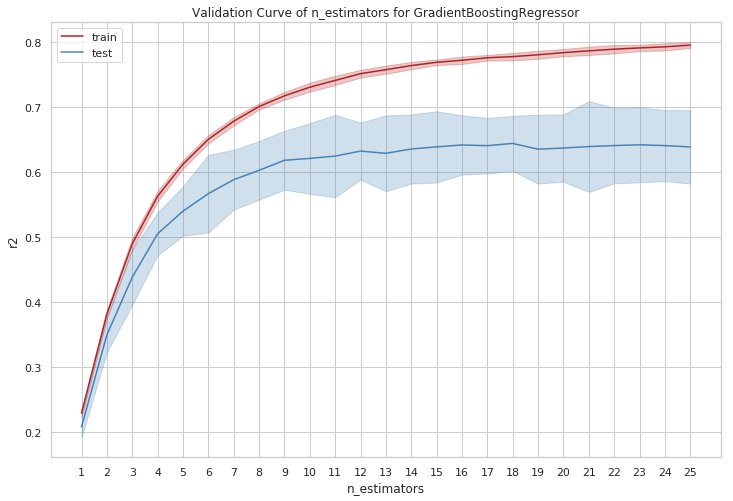

In [127]:
estimator = GradientBoostingRegressor().set_params(**best_params)
param_range = [int(x) for x in np.linspace(start=1, stop=25, num=25)]
validation = validation_curve(listings_small, "price", estimator, 
                              'n_estimators', param_range, iterations=3)

For this curve, we'll pick the first point where the test curve score stops increasing to minimize overfitting and bias.  Note that the lower value produces a more efficient model in terms of time complexity as well.  For these reasons, 12 will be chosen.

Also note that the appears to be quite a bit of variance.

In [128]:
best_params['n_estimators'] = 12
estimator = GradientBoostingRegressor().set_params(**best_params)

#### Learning Rate

In [129]:
np.random.seed(4523145)

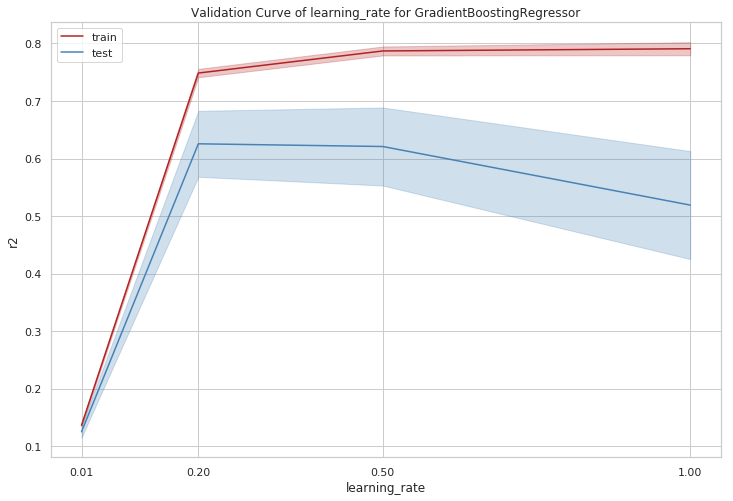

In [130]:
param_range = [0.01, 0.2, 0.5, 1]
validation = validation_curve(listings_small, "price", estimator, 
                              'learning_rate', param_range, iterations=3)

The optimum value may be in the range between 0.01 and 0.50  These areas will be explored separately with additional validation curves.

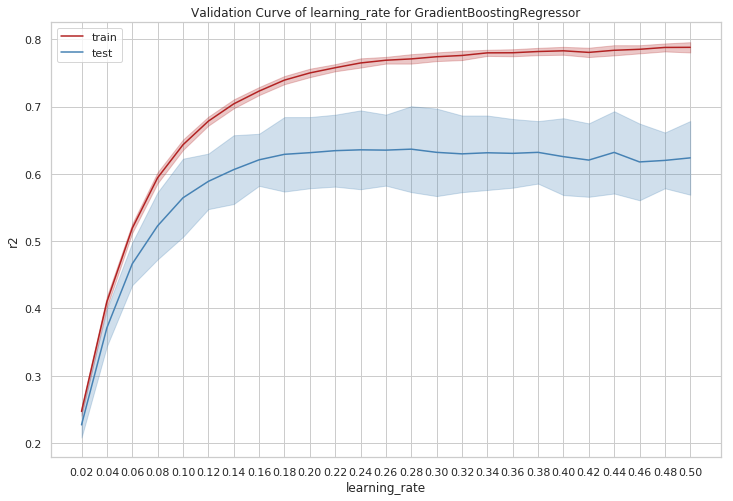

In [131]:
param_range = [x for x in np.linspace(start=0.02, stop=0.50, num=25)]
validation = validation_curve(listings_small, "price", estimator, 
                              'learning_rate', param_range, iterations=3)

The optimal value appears to be about 0.20 which was found by the grid search.  Note again that there appears to still be quite a bit of variance.

In [132]:
best_params['learning_rate'] = 0.2
estimator = GradientBoostingRegressor().set_params(**best_params)

#### max_depth

In [133]:
np.random.seed(523432)

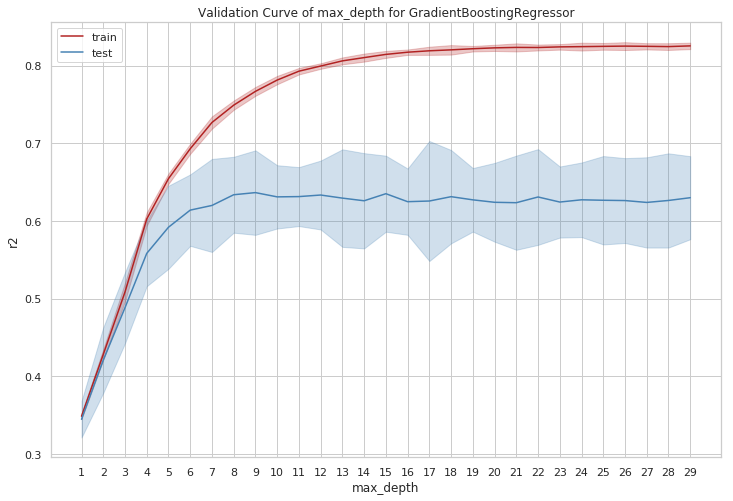

In [134]:
param_range = range(1, 30)
validation = validation_curve(listings_small, "price", estimator, 
                              'max_depth', param_range, iterations=3)


There is a slight increase increase in the test score from 7 to 9 but a large jump in variance.  Because of this, 7 will be used.

In [135]:
best_params['max_depth'] = 7
estimator = GradientBoostingRegressor().set_params(**best_params)

#### min_samples_leaf

In [136]:
np.random.seed(4218)

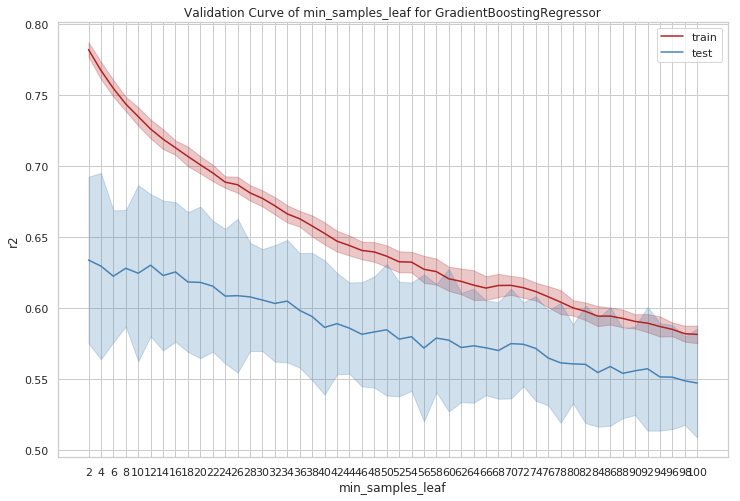

In [137]:
param_range = [int(x) for x in np.linspace(start=2, stop=100, num=50)]
validation = validation_curve(listings_small, "price", estimator, 
                              'min_samples_leaf', param_range, iterations=3)


Both the training curve and the test curve steadily decrease throughout, although the training curve decreases more rapidly. We'll choose 14 so that some of the gap between the curves is closed while only slightly increasing bias.

In [138]:
best_params['min_samples_leaf'] = 14
estimator = GradientBoostingRegressor().set_params(**best_params)

#### min_samples_split

In [139]:
np.random.seed(4128)

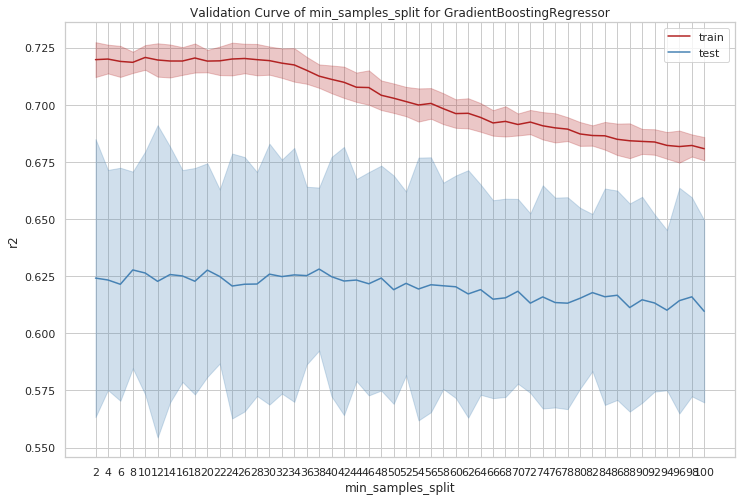

In [140]:
param_range = [int(x) for x in np.linspace(start=2, stop=100, num=50)]
validation = validation_curve(listings_small, "price", estimator, 
                              'min_samples_split', param_range, iterations=3)

To minimize variance without increasing bias, `min_samples_split` will be set to 38.

In [141]:
best_params['min_samples_split'] = 38
estimator = GradientBoostingRegressor().set_params(**best_params)

### Learning Curves
Now learning curves will be used to further examine the bias variance tradeoff and determine if more data would help.

In [142]:
np.random.seed(5492)

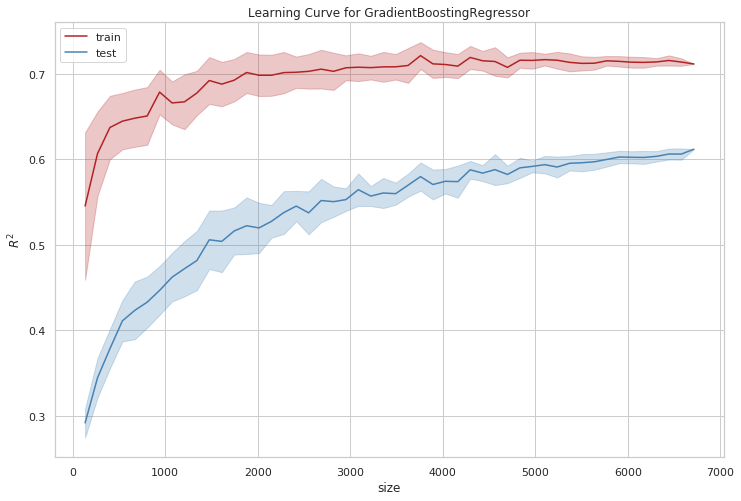

In [143]:
learning = learning_curve_2(listings_small, "price", estimator, iterations=20, chunks=50)

Again, because of the way these learning curves were generated, the possibility of picking a very easy or very hard to model test set is present (although lesser now that listings with `price`>1000 were removed. Since this is the best model thus far available (without including additional predictive features), we'll edit the learning curve procedure to such that the training set will be randomly selected for each iteration.  This is will allow us to better assess whether or not more data would help and where we are currently in the bias variance tradedoff.

In [144]:
def learning_curve_3(data, target, estimator, chunks=50, test_size=0.2, iterations=50):
    
    n = data.shape[0]
    test_n = int(np.round(n*test_size,0))
    train_n = n-test_n
    

    
#     test_y, test_X = dmatrices(formula, test_set)
    
    size_interval = train_n/chunks
    sizes = [int(size_interval*i) for i in range(1, chunks+1)]
    
    train = []
    test = []
    train_std = []
    test_std = []
    
    for s in sizes:
        
        train_chunk = []
        test_chunk = []
        
        
        for _ in range(iterations):
            
            # Shifted test set selection within iteration
            indices = deepcopy(data.index).values
            random.shuffle(indices)
    
            test_indices = indices[0:test_n]
            train_indices = indices[test_n:]
    
            train_set = data.iloc[train_indices]
            test_set = data.iloc[test_indices]
            
            # Select train sample and get score for iteration
            train_sample = train_set.sample(n=s)

            estimator.fit(train_sample.drop(columns=[target]), train_sample[target])
            test_score = estimator.score(test_set.drop(columns=[target]), test_set[target])
            train_score = estimator.score(train_sample.drop(columns=[target]), train_sample[target])
            
            train_chunk.append(train_score)
            test_chunk.append(test_score)
            
        train.append(np.mean(train_chunk))
        test.append(np.mean(test_chunk))
        train_std.append(np.std(train_chunk))
        test_std.append(np.std(test_chunk))
        
    learning = pd.DataFrame({'size':sizes,
                  'train':train,
                  'train_std': train_std,
                  'test':test,
                  'test_std': test_std})
    
    
    # Getting bounds of confidence interval
    estimator_name = str(estimator).split('(')[0]
    train_upper = learning['train'] + learning['train_std']
    train_lower = learning['train'] - learning['train_std']
    test_upper = learning['test'] + learning['test_std']
    test_lower = learning['test'] - learning['test_std']
    
    # Plotting the curve
    figure = plt.figure(figsize=(12, 8))

    axes = figure.add_subplot(1, 1, 1)
    axes.plot(learning["size"], learning["train"], '-', label='train', color ='firebrick')
    axes.plot(learning["size"], learning["test"], '-', label='test', color = 'steelblue')
    axes.fill_between(learning["size"], train_upper, train_lower, color='firebrick', alpha=0.25)
    axes.fill_between(learning["size"], test_upper, test_lower, color='steelblue', alpha=0.25)
    axes.legend()
    axes.set_xlabel("size")
    axes.set_ylabel(r"$R^{2}$")
    axes.set_title("Learning Curve for " + estimator_name)
    
    plt.show()
    plt.close()
    
    return learning

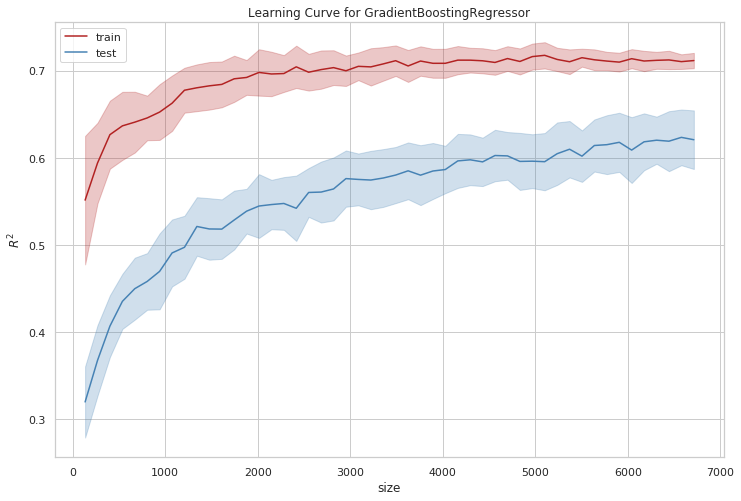

In [145]:
learning = learning_curve_3(listings_small, "price", estimator, iterations=50, chunks=50)

We are still in a high variance zone at this point.  However, the training curve has leveled out while the test curve is still increasing while using the totality of the data available.  This suggest that more data would improve cross validation scores and lower the variance.

### Residuals

Now let's take a look at a couple residual plots in terms of the target.

In [146]:
np.random.seed(542353)

In [147]:
estimator = GradientBoostingRegressor().set_params(**best_params)
estimator.fit(listings_small.drop(columns=['price']), listings_small['price'])
y_predict = estimator.predict(listings_small.drop(columns=['price']))
residuals = listings_small['price'] - y_predict

Text(0, 0.5, 'residuals')

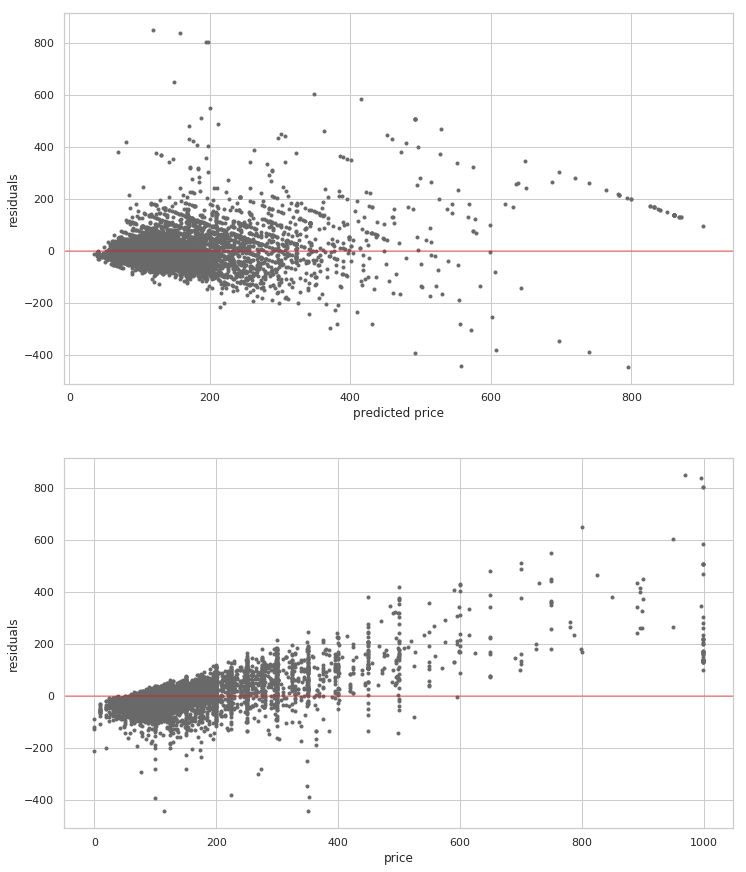

In [148]:
figure = plt.figure(figsize=(12, 15))

axes = figure.add_subplot(2, 1, 1)
axes.plot(y_predict, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('predicted price')
axes.set_ylabel('residuals')

axes = figure.add_subplot(2, 1, 2)
axes.plot(listings_small.price, residuals, '.', color='dimgray')
axes.axhline(y=0.0, color = 'red', alpha=0.4)
axes.set_xlabel('price')
axes.set_ylabel('residuals')

These residuals still have the same pattern as before: as price increases, the model underestimates the price.  This further suggests that there is some feature missing from the data that correlates positively with price.  It also could be due to the uneven sampling of low priced listings vs high priced listings.

### Cross Validation Bootstrap
Now that our model has been developed.  We'll use a cross-validation bootstrap so that we can compare to the previous best model. 

In [149]:
np.random.seed(542354)

In [150]:
# Get scores
estimator = GradientBoostingRegressor().set_params(**best_params)
scores_gb = multi_cross_val(listings_small, 'price', estimator)

# Resample Scores
sigma_gb_resample = bootstrap_sample(scores_gb["sigma"], np.mean)
r2_gb_resample = bootstrap_sample(scores_gb["r2"], np.mean)
mae_gb_resample = bootstrap_sample(scores_gb["mae"], np.mean)

# Find credible intervals
sigma_gb_cred = np.array2string(stats.mstats.mquantiles(sigma_gb_resample, [0.25, .975]), precision=3, separator=',')
r2_gb_cred = np.array2string(stats.mstats.mquantiles(r2_gb_resample, [0.25, .975]), precision=3, separator=',')
mae_gb_cred = np.array2string(stats.mstats.mquantiles(mae_gb_resample, [0.25, .975]), precision=3, separator=',')

# Print results
print("Sigma Resample Mean: {0:.3f}".format(np.mean(sigma_gb_resample)))
print("95% Credible Interval for sigma: ", sigma_gb_cred)
print("R2 Resample Mean: {0:.3f}".format(np.mean(r2_gb_resample)))
print("95% Credible Interval for R2: ", r2_gb_cred)
print("mae Resample Mean: {0:.3f}".format(np.mean(mae_gb_resample)))
print("95% Credible Interval for mae: ", mae_gb_cred)

Sigma Resample Mean: 74.720
95% Credible Interval for sigma:  [73.958,76.786]
R2 Resample Mean: 0.623
95% Credible Interval for R2:  [0.618,0.64 ]
mae Resample Mean: 44.339
95% Credible Interval for mae:  [44.146,44.936]


In [151]:
difference = {}
difference["sigma"] = sigma_gb_resample - sigma_rf_resample
difference["r2"] = r2_gb_resample - r2_rf_resample
difference["mae"] = mae_gb_resample - mae_rf_resample

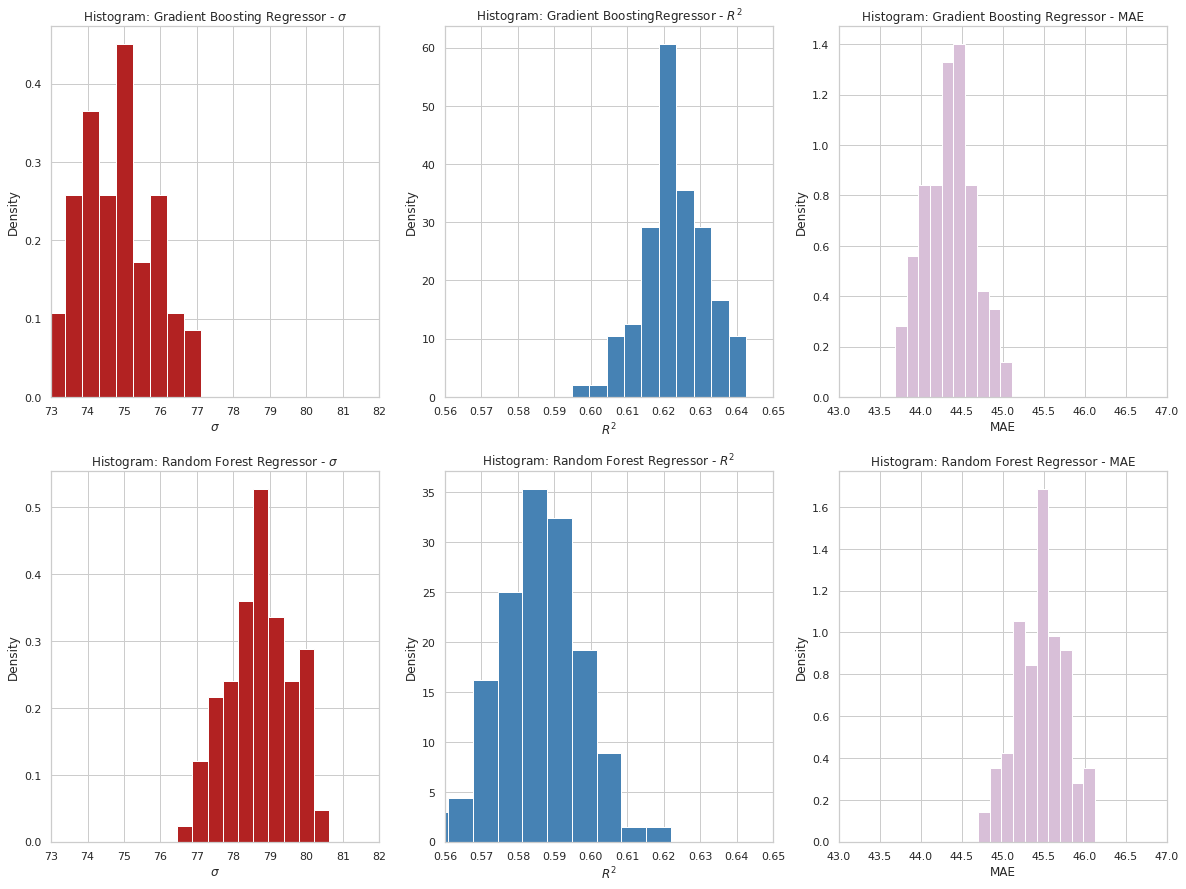

In [152]:
figure = plt.figure(figsize=(20, 15))

axes = figure.add_subplot(2, 3, 1)
axes.hist(sigma_gb_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Gradient Boosting Regressor - $\sigma$")
axes.set_xlim([73, 82])

axes = figure.add_subplot(2, 3, 4)
axes.hist(sigma_rf_resample, color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Random Forest Regressor - $\sigma$")
axes.set_xlim([73, 82])


axes = figure.add_subplot(2, 3, 2)
axes.hist(r2_gb_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Gradient BoostingRegressor - $R^{2}$")
axes.set_xlim([.56, .65])

axes = figure.add_subplot(2, 3, 5)
axes.hist(r2_rf_resample, color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Random Forest Regressor - $R^{2}$")
axes.set_xlim([.56, .65])

axes = figure.add_subplot(2, 3, 3)
axes.hist(mae_gb_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Gradient Boosting Regressor - MAE")
axes.set_xlim([43, 47])

axes = figure.add_subplot(2, 3, 6)
axes.hist(mae_rf_resample, color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Random Forest Regressor - MAE")
axes.set_xlim([43, 47])

plt.show()
plt.close()

This definitely looks like an improvement.  Let's take a look at the differences between the two models evaluation scores and the probability that the $R^{2}$ for the Gradient Boosting Regresssor performs better.

/home/sam/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 1.0, 'Histogram: Difference - MAE')

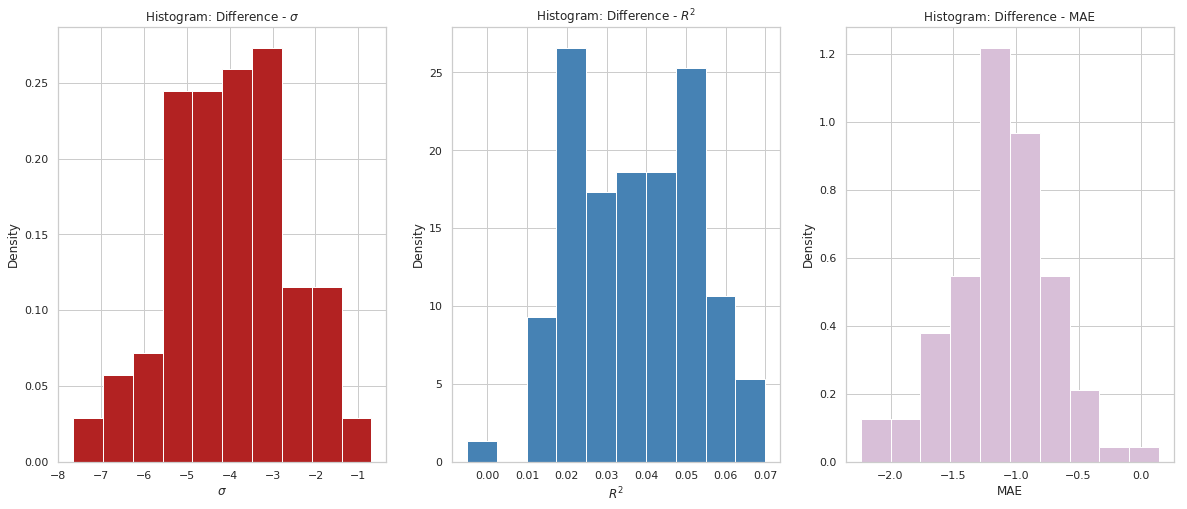

In [153]:
figure = plt.figure(figsize=(20, 8))

axes = figure.add_subplot(1, 3, 1)
axes.hist(difference["sigma"], color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Difference - $\sigma$")


axes = figure.add_subplot(1, 3, 2)
axes.hist(difference["r2"], color='steelblue', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$R^{2}$")
axes.set_title(r"Histogram: Difference - $R^{2}$")

axes = figure.add_subplot(1, 3, 1)
axes.hist(difference["sigma"], color='firebrick', density=True)
axes.set_ylabel("Density")
axes.set_xlabel(r"$\sigma$")
axes.set_title(r"Histogram: Difference - $\sigma$")


axes = figure.add_subplot(1, 3, 3)
axes.hist(difference["mae"], color='thistle', density=True)
axes.set_ylabel("Density")
axes.set_xlabel("MAE")
axes.set_title(r"Histogram: Difference - MAE")

In [154]:
print("P(GBR R2 > Random Forest R2) = {0:.2f}".format(np.mean(difference["r2"]>0)))

P(GBR R2 > Random Forest R2) = 0.99


From this, we can conclude with high certainty that the Gradient Boosting model produces a higher cross validation $R^{2}$ than the other models.

#### Feature Importances
Let's now take a look at the feature importances for the Gradient Boosting Regressor.

In [155]:
np.random.seed(45235)

In [156]:
estimator = GradientBoostingRegressor().set_params(**best_params)
X = listings_small.drop(columns=['price'])
y = listings_small.price
estimator.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=14,
             min_samples_split=38, min_weight_fraction_leaf=0.0,
             n_estimators=12, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

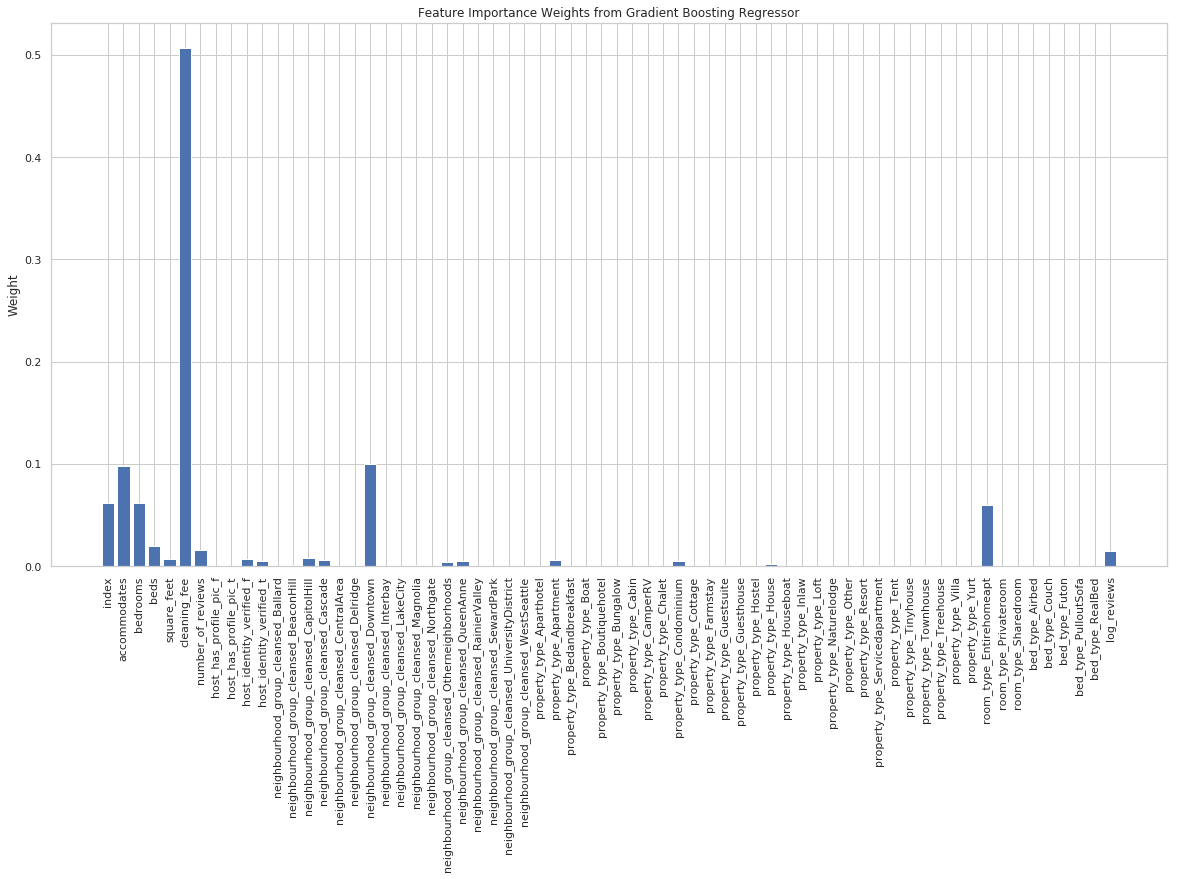

In [157]:
figure = plt.figure(figsize=(20,10))

axes = figure.add_subplot(1, 1, 1)

axes.bar(list(X.columns), estimator.feature_importances_)
axes.set_xticks(np.arange(len(X.columns)))
axes.set_xticklabels(list(X.columns), rotation = 90)

axes.set_ylabel("Weight")
axes.set_title("Feature Importance Weights from Gradient Boosting Regressor")

plt.show()
plt.close()

Not surprisingly, many of the features that were found to be important for the Random Forest Regressor model were also important for the Gradient Boosting model.  In particular, `cleaning_fee` was again found to be the most important feature.  This further supports the theory that the true price is the sum of the `cleaning_fee` and the `price`.

# Summary

While performing EDA, it was discovered that many variables correlated with `price`. The distribution of `price`, however, was heavily skewed whereas `log_price` was not. Linear Regression produced an $R^{2}$ of 0.31.  Performing Regression on `log_price` and taking the inverse to produce `price` didn't result in any improvement.  However, it is likely that targetting `log_price` alone, without taking the inverse after the fact, would produce a higher $R^{2}$.a  Targetting an adjusted price of `price` summed with `cleaning_fee` did produce an improvement. The goal was to set a baseline for each algorithm without making many transformation so this was not used for the rest of the project.  However, it is certainly an idea to explore as the theme of `cleaning_fee` as a strong predictor was found throughout.

Using a Decision Tree Regressor improved upon the Linear Regression Model with a cross-validation 0.40 $R^{2}$. The Random Forest Model brought the score to a 0.50 $R^{2}$, 51.95 MAE, and 118.11 sigma.  In the residual plot of `residuals` vs `price`, a clear linear trend was observed. In addition, it was observed the estimates for prices greater than \$1000 were very poor. This could be due to the sparseness in the range. Because of this, listings with `price` greater than 1000 were removed from the data.  An attempt to leverage the trend was made by applying a Gradient Boosting Regressor to the data.  This, combined with the removal of outliers, did provide a substantial improvement resulting in an $R^{2}$ of 0.62.

Overall, while the score isn't perfect and there a present trend in the residuals, the final model outperformed expectations given the truncated set of features.

General Observations:
* `cleaning_fee` was the most important feature
* some listings were significantly harder to model than others
* Trends were present in the residual plot of the final model
* The data past a `price` of 1000 was sparse

Further Improvements:
* Applying a more rigorous solution to the missing values for `square_feet`
* Oversampling the higher price listings or undersampling low `price` listings
* Taking a deeper look at the `cleaning_fee` and `price` relationship; further exploring the idea of 
    targetting `adj_price`
* Using the full set of features available


As a final note, I'll present all the features available in the original data set and suggest further fields, not present in that set of features, that may also improve the model.

In [158]:
pd.set_option('display.max_rows', 500)
pd.Series(listings_original.columns)

0                                                id
1                                       listing_url
2                                         scrape_id
3                                      last_scraped
4                                              name
5                                           summary
6                                             space
7                                       description
8                               experiences_offered
9                             neighborhood_overview
10                                            notes
11                                          transit
12                                           access
13                                      interaction
14                                      house_rules
15                                    thumbnail_url
16                                       medium_url
17                                      picture_url
18                                   xl_picture_url
19          

Just by taking a cursory glance at this list, I see the following features that may be helpful that weren't used:
* `guests_included` - results in higher price
* `amenities` - more amenities provided results in higher price
* `neighbourhood` - may correlate with features used already, but still may help
* `review_scores_rating` - higher scores results in higher price
* `has_availability` - if no availability, this is most likely because the listings is a good deal; so availability   would result in a higher price

These are just a few though.  Plenty of the other fields could be helpful as well.  Even fields with lengthy paragraphs could be scraped for additional features.

Some things missing from the set that could help are:
* day of the week
* time of year (season, vacation time, etc.)
